In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pickle
import numpy as np

### 1. load, make dummy and add the diff columns

In [2]:
df = pd.read_csv('data/df_feats_assembled.csv')

# make dummies for agent, gender, first level, last_level
df_model = pd.get_dummies(df, columns=['agent', 'gender','first_level','last_level'], drop_first=True, dtype=int)

# rescale the timestamp so easier to work with
ref_ts = df_model.registration.min()
for col in ['registration','max_ts','min_ts']:
    df_model[col] = (df_model[col] - ref_ts)/3600/1000

# get the diff column
cols = [x for x in df_model.columns if f"{x}_recent" in df_model.columns]
df_model_change = df_model.copy()
for col in cols:
    df_model_change[f"{col}_recent_diff"] = df_model_change[f"{col}_recent"] - df_model_change[col]

In [3]:
df_model_change.head(5)

,userId,churn,location,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,Thumbs Up_recent_diff,Help_recent_diff,Upgrade_recent_diff,Error_recent_diff,Submit Upgrade_recent_diff,count_recent_diff,status_307_count_recent_diff,get_count_recent_diff,total_time_recent_diff,avg_gap_time_recent_diff
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA",7223.782222,0.000399,0.008112,0.035372,0.011037,0.011037,0.011436,...,-0.005591,-0.000346,-0.001197,0.001223,-0.000532,-5867,-0.005270,0.004490,-910.941111,0.666488
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA",8308.000000,0.000000,0.006814,0.028109,0.009370,0.002129,0.009370,...,-0.007862,-0.001278,0.000000,-0.001278,0.000000,-1835,-0.009107,-0.007010,-1204.659444,-17.430508
2,1321163,0,"Birmingham-Hoover, AL",8277.442500,0.000000,0.008943,0.032088,0.005260,0.020516,0.012099,...,0.010179,0.004990,-0.002104,-0.000526,-0.000526,-1284,-0.001153,-0.026644,-1121.332500,22.380930
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL",7746.146389,0.000678,0.006784,0.044776,0.000678,0.041384,0.018318,...,-0.009259,-0.003392,-0.006106,0.000000,-0.000678,-1315,-0.006251,0.008052,-1267.011944,-9.884078
4,1331962,0,"Edwards, CO",8023.105278,0.000000,0.011004,0.031637,0.009629,0.001376,0.013755,...,0.006487,0.000290,0.000000,-0.001376,0.000000,-371,0.009992,-0.005603,-1093.265278,-157.739278


In [4]:
# this split will be the same for all models
X, y = df_model_change.drop(columns=['churn', 'location']).values, df_model_change.churn.values
feats = df_model_change.drop(columns=['churn', 'location']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [62]:
X_train.shape, X_test.shape

((17808, 74), (4453, 74))

### 2. random forest

In [5]:
def do_fit():
    '''
      use gridsearch for randomforest
    '''
    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                       param_grid = {'min_samples_leaf':[3,4,5,6,7,10]},
                       cv = ShuffleSplit(n_splits=4, random_state=42),
                       scoring = ['f1', 'roc_auc'],
                       refit = 'f1',
                       verbose = 3)
    
    clf.fit(X_train, y_train)
    
    print('best param:', clf.best_params_)
    print('f1 score on test:', f1_score(clf.predict(X_test), y_test))
    
    return clf, feats

In [6]:
clf, feats = do_fit()

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END min_samples_leaf=3; f1: (test=0.839) roc_auc: (test=0.951) total time=   8.2s
[CV 2/4] END min_samples_leaf=3; f1: (test=0.840) roc_auc: (test=0.944) total time=   8.2s
[CV 3/4] END min_samples_leaf=3; f1: (test=0.835) roc_auc: (test=0.959) total time=   8.1s
[CV 4/4] END min_samples_leaf=3; f1: (test=0.843) roc_auc: (test=0.949) total time=   8.2s
[CV 1/4] END min_samples_leaf=4; f1: (test=0.839) roc_auc: (test=0.950) total time=   8.1s
[CV 2/4] END min_samples_leaf=4; f1: (test=0.840) roc_auc: (test=0.939) total time=   8.2s
[CV 3/4] END min_samples_leaf=4; f1: (test=0.836) roc_auc: (test=0.961) total time=   8.0s
[CV 4/4] END min_samples_leaf=4; f1: (test=0.835) roc_auc: (test=0.953) total time=   8.1s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.848) roc_auc: (test=0.951) total time=   7.9s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.836) roc_auc: (test=0.943) total time=   7.9s
[CV 3/4] END min_samples_leaf=

In [7]:
with open('random_forest_no_state.pickle', 'wb') as fid:
    pickle.dump(clf.best_estimator_, fid)

### 3. logistic and svc

In [8]:
def do_fit_logistic():
    '''
      logistic regression; use powertransformer as preprocess as the counts are positive only and very skewed
    '''
    pipeline = Pipeline([
        ('preprocess', PowerTransformer()),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=10000))
    ])
    
    clf = GridSearchCV(pipeline,
                       param_grid = {'clf__C':[0.1,0.2,0.3,0.5,0.7,1.0,3.0,5.0,10.0]},
                       cv = ShuffleSplit(n_splits=4, random_state=42),
                       scoring = ['f1', 'roc_auc'],
                       refit = 'f1',
                       verbose = 3)
    
    clf.fit(X_train, y_train)
    
    print('best param:', clf.best_params_)
    print('f1 score on test:', f1_score(clf.predict(X_test), y_test))
    
    return clf, feats

In [9]:
clf, feats = do_fit_logistic()

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END clf__C=0.1; f1: (test=0.799) roc_auc: (test=0.951) total time=   1.2s
[CV 2/4] END clf__C=0.1; f1: (test=0.796) roc_auc: (test=0.941) total time=   1.3s
[CV 3/4] END clf__C=0.1; f1: (test=0.802) roc_auc: (test=0.960) total time=   1.3s
[CV 4/4] END clf__C=0.1; f1: (test=0.800) roc_auc: (test=0.954) total time=   1.3s
[CV 1/4] END clf__C=0.2; f1: (test=0.801) roc_auc: (test=0.951) total time=   1.2s
[CV 2/4] END clf__C=0.2; f1: (test=0.793) roc_auc: (test=0.942) total time=   1.4s
[CV 3/4] END clf__C=0.2; f1: (test=0.803) roc_auc: (test=0.960) total time=   1.3s
[CV 4/4] END clf__C=0.2; f1: (test=0.798) roc_auc: (test=0.954) total time=   1.3s
[CV 1/4] END clf__C=0.3; f1: (test=0.801) roc_auc: (test=0.951) total time=   1.2s
[CV 2/4] END clf__C=0.3; f1: (test=0.793) roc_auc: (test=0.942) total time=   1.3s
[CV 3/4] END clf__C=0.3; f1: (test=0.803) roc_auc: (test=0.960) total time=   1.3s
[CV 4/4] END clf__C=0.3; f1

In [10]:
with open('logistic_regression_no_state.pickle', 'wb') as fid:
    pickle.dump(clf.best_estimator_, fid)

In [11]:
def importance_plot(importance, cols, figsize=(10,20)):
    '''
      plot importance vs features
    '''
    tmp = pd.DataFrame(importance.reshape(-1,1), index=cols)
    tmp.reset_index(inplace=True)
    tmp.columns = ('feature','importance')
    plt.figure(figsize = figsize)
    sns.barplot(data = tmp,
                x = 'importance',
                y = 'feature',
                order = tmp.sort_values(by='importance').feature)

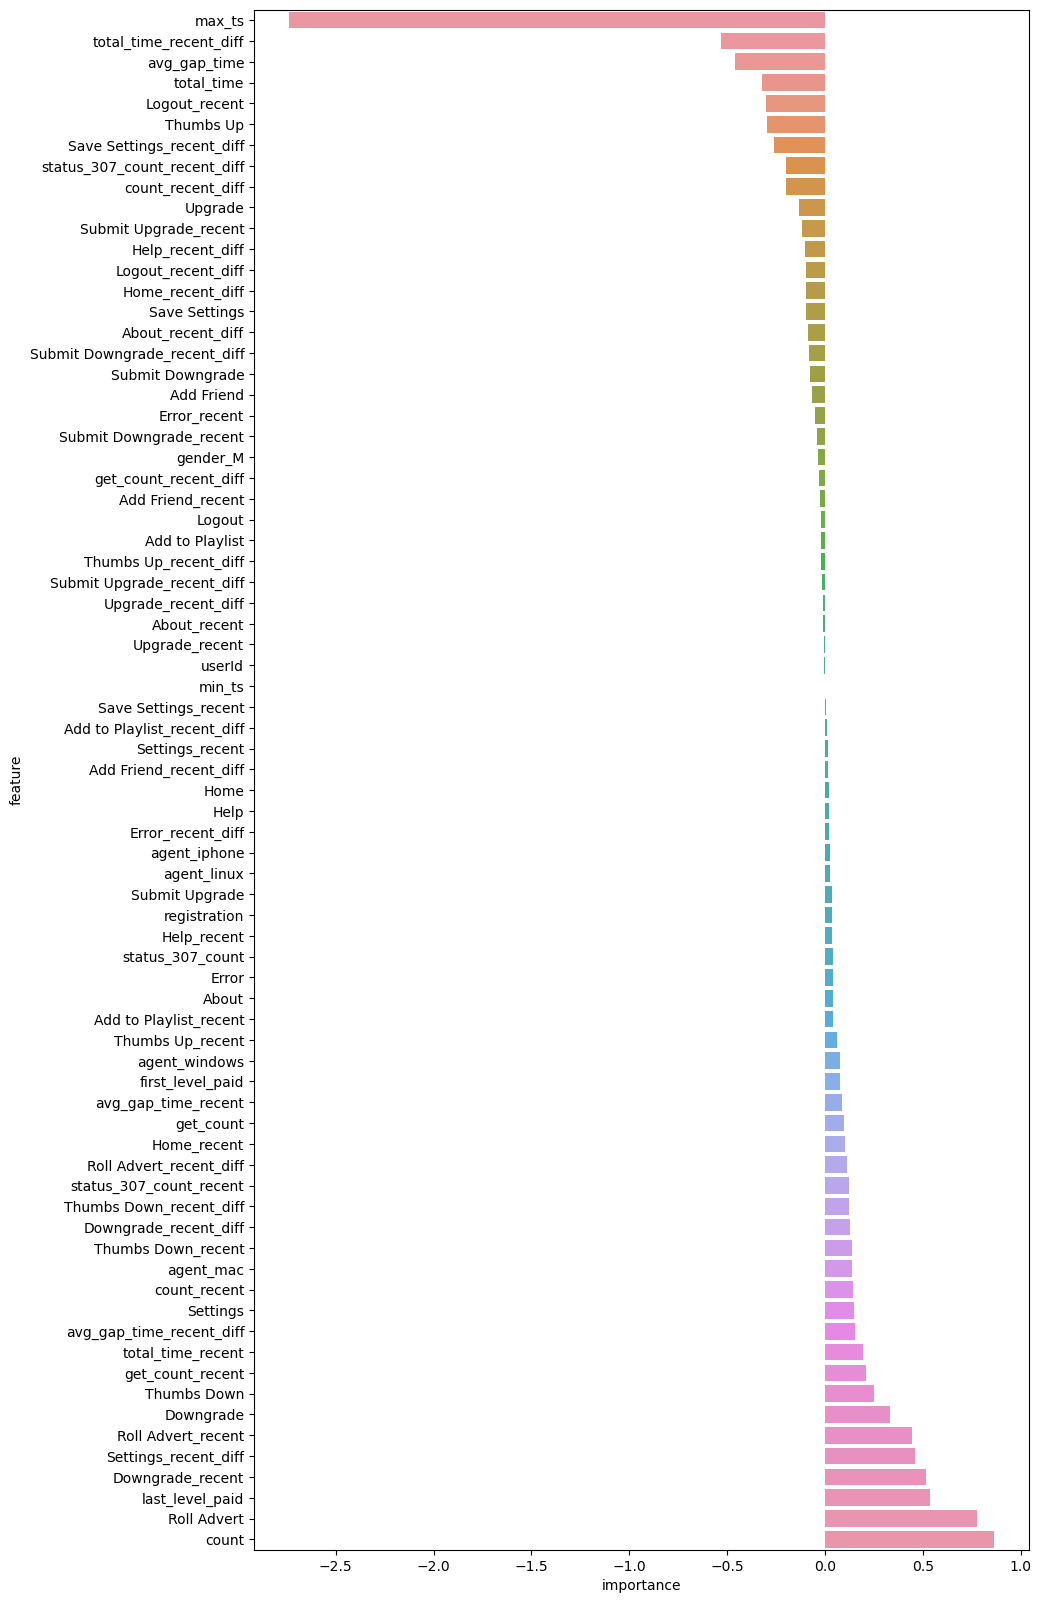

In [12]:
importance_plot(clf.best_estimator_[1].coef_, feats)

In [13]:
def do_fit_svc():
    '''
      svc
    '''
    pipeline = Pipeline([
        ('preprocess', PowerTransformer()),
        ('clf', SVC(class_weight='balanced'))
    ])
    
    clf = GridSearchCV(pipeline,
                       param_grid = {'clf__C':[0.1,0.3,0.5,0.7,1.0,1.2,1.5,2.0],
                                     'clf__kernel':['rbf']},
                       cv = ShuffleSplit(n_splits=4, random_state=42),
                       scoring = ['f1', 'roc_auc'],
                       refit = 'f1',
                       verbose = 3)
    
    clf.fit(X_train, y_train)
    
    print('best param:', clf.best_params_)
    print('f1 score on test:', f1_score(clf.predict(X_test), y_test))
    
    return clf, feats

In [14]:
clf, feats = do_fit_svc()

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV 1/4] END clf__C=0.1, clf__kernel=rbf; f1: (test=0.803) roc_auc: (test=0.944) total time=  17.3s
[CV 2/4] END clf__C=0.1, clf__kernel=rbf; f1: (test=0.785) roc_auc: (test=0.933) total time=  17.6s
[CV 3/4] END clf__C=0.1, clf__kernel=rbf; f1: (test=0.809) roc_auc: (test=0.953) total time=  17.7s
[CV 4/4] END clf__C=0.1, clf__kernel=rbf; f1: (test=0.791) roc_auc: (test=0.946) total time=  17.2s
[CV 1/4] END clf__C=0.3, clf__kernel=rbf; f1: (test=0.813) roc_auc: (test=0.948) total time=  15.3s
[CV 2/4] END clf__C=0.3, clf__kernel=rbf; f1: (test=0.797) roc_auc: (test=0.938) total time=  15.8s
[CV 3/4] END clf__C=0.3, clf__kernel=rbf; f1: (test=0.813) roc_auc: (test=0.958) total time=  15.0s
[CV 4/4] END clf__C=0.3, clf__kernel=rbf; f1: (test=0.798) roc_auc: (test=0.951) total time=  14.5s
[CV 1/4] END clf__C=0.5, clf__kernel=rbf; f1: (test=0.810) roc_auc: (test=0.948) total time=  13.8s
[CV 2/4] END clf__C=0.5, clf__kernel=rbf

In [15]:
clf.best_params_

{'clf__C': 0.7, 'clf__kernel': 'rbf'}

In [16]:
clf = Pipeline([
        ('preprocess', PowerTransformer()),
        ('clf', SVC(class_weight='balanced', C=0.7, kernel='rbf', probability=True))
    ])

In [17]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess', PowerTransformer()),
                ('clf', SVC(C=0.7, class_weight='balanced', probability=True))])

In [18]:
f1_score(clf.predict(X_test), y_test)

0.8199546485260772

In [20]:
with open('svm_no_state.pickle', 'wb') as fid:
    pickle.dump(clf, fid)

### 4. xgboost

In [22]:
from xgboost import XGBClassifier
from itertools import product
from collections import defaultdict
from copy import deepcopy
from cv_result_analyzer import CVResultAnalyzer

def f1_eval_error(y_true, dtrain):
    y_pred = np.where(dtrain>0.5, 1.0, 0.0)
#     return 'f1_eval', f1_score(y_pred, y_true)
    return 1-f1_score(y_pred, y_true)

In [23]:
class CV_xgboost(CVResultAnalyzer):
    '''
       helper class to run grid search on xgboost
    '''
    def __init__(self, obj="binary:logistic"):
        self.objective = obj
    
    def fit(self, X, y, param_grid, kf=StratifiedKFold(n_splits=4), verbose=True, target='1'):
        ''' do some cv on param_grid '''
        cols = defaultdict(list)
        
        # loop over each param combination
        param_names, param_vals = list(zip(*param_grid.items()))
        for param_val in product(*param_vals):
            param = dict(zip(param_names, param_val))
            print(f"doing {param}")
            for k, v in param.items():
                cols[k].append(v)
            
            # loop over the splits
            scores = []
            for train_idx, test_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                X_test, y_test = X[test_idx], y[test_idx]
                clf = XGBClassifier(**param, objective=self.objective)
                clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
                scores.append(clf.best_score)
            print(scores)
            
            # store the result for this test
            for isplit, score in enumerate(scores):
                cols[f'split_{isplit}'].append(score)
            cols['mean_test'].append(np.mean(scores))
            cols['std_test'].append(np.std(scores))
        
        # turn it into pd
        self.result_df = pd.DataFrame.from_dict(cols)
        self.result_df['target'] = target        
        self.result_df.reset_index(names=['id'], inplace=True) # this is useful in scatterplot
    
    def refit(self, X, y, best_param, kf=StratifiedKFold(n_splits=4), verbose=True):
        ''' 
          keep the clf for each split and when predict, give the average
          useful to fit at a lower learning rate
        '''
        self.clfs = []
        for train_idx, test_idx in kf.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            best_param['n_estimators'] = 10000 # first do an early stop
            clf = XGBClassifier(**best_param, objective=self.objective)
            clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
            # refit at the best point
            best_param['n_estimators'] = clf.best_ntree_limit # then do a refit at the best iter
            clf = XGBClassifier(**best_param, objective=self.objective)
            clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
            self.clfs.append(deepcopy(clf))
    
    def predict(self, X):
        p = self.predict_proba(X)[:,1]
        y_pred = np.where(p>0.5, 1, 0)
        return y_pred
    
    def predict_proba(self, X):
        for i, clf in enumerate(self.clfs):
            if i == 0:
                p = clf.predict_proba(X)
            else:
                p = p + clf.predict_proba(X)
        p = p / len(self.clfs)
        return p

In [25]:
(y_train == 0).sum() / (y_train == 1).sum()

3.506072874493927

In [26]:
param_grid = {'gamma': [0,1,3],
              'max_depth': [2,3,4,6,8],
              'min_child_weight': [0,1,3,5],
              'scale_pos_weight': [1,3.5],
              'n_estimators': [10000],
              'early_stopping_rounds': [20],
              'learning_rate': [0.3],
              'eval_metric': [f1_eval_error]}

In [27]:
cv_helper = CV_xgboost()
cv_helper.fit(X_train, y_train, param_grid, kf=ShuffleSplit(n_splits=4, random_state=42), verbose=10)

doing {'gamma': 0, 'max_depth': 2, 'min_child_weight': 0, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.53104	validation_0-f1_eval_error:0.29226
[10]	validation_0-logloss:0.24577	validation_0-f1_eval_error:0.21776
[20]	validation_0-logloss:0.21695	validation_0-f1_eval_error:0.19095
[30]	validation_0-logloss:0.20278	validation_0-f1_eval_error:0.17403
[40]	validation_0-logloss:0.19583	validation_0-f1_eval_error:0.16712
[50]	validation_0-logloss:0.19198	validation_0-f1_eval_error:0.17033
[60]	validation_0-logloss:0.18800	validation_0-f1_eval_error:0.16120
[70]	validation_0-logloss:0.18640	validation_0-f1_eval_error:0.16006
[80]	validation_0-logloss:0.18543	validation_0-f1_eval_error:0.16438
[88]	validation_0-logloss:0.18476	validation_0-f1_eval_error:0.16484
[0]	validation_0-logloss:0.52760	validation_0-f1_eval_error:0.28485
[10]	validation_0-logloss:0.2461

[10]	validation_0-logloss:0.29881	validation_0-f1_eval_error:0.21986
[20]	validation_0-logloss:0.26466	validation_0-f1_eval_error:0.18392
[30]	validation_0-logloss:0.24835	validation_0-f1_eval_error:0.17905
[40]	validation_0-logloss:0.23662	validation_0-f1_eval_error:0.16972
[50]	validation_0-logloss:0.23176	validation_0-f1_eval_error:0.16870
[58]	validation_0-logloss:0.22777	validation_0-f1_eval_error:0.16912
[0]	validation_0-logloss:0.56226	validation_0-f1_eval_error:0.25887
[10]	validation_0-logloss:0.30490	validation_0-f1_eval_error:0.22557
[20]	validation_0-logloss:0.27287	validation_0-f1_eval_error:0.20049
[30]	validation_0-logloss:0.25602	validation_0-f1_eval_error:0.19107
[40]	validation_0-logloss:0.24880	validation_0-f1_eval_error:0.18555
[50]	validation_0-logloss:0.24279	validation_0-f1_eval_error:0.18317
[60]	validation_0-logloss:0.24015	validation_0-f1_eval_error:0.18518
[70]	validation_0-logloss:0.23852	validation_0-f1_eval_error:0.18765
[71]	validation_0-logloss:0.23852	v

[10]	validation_0-logloss:0.24577	validation_0-f1_eval_error:0.21776
[20]	validation_0-logloss:0.21695	validation_0-f1_eval_error:0.19095
[30]	validation_0-logloss:0.20304	validation_0-f1_eval_error:0.17403
[40]	validation_0-logloss:0.19647	validation_0-f1_eval_error:0.17194
[50]	validation_0-logloss:0.19274	validation_0-f1_eval_error:0.16553
[60]	validation_0-logloss:0.18907	validation_0-f1_eval_error:0.16164
[70]	validation_0-logloss:0.18767	validation_0-f1_eval_error:0.16393
[80]	validation_0-logloss:0.18642	validation_0-f1_eval_error:0.16164
[81]	validation_0-logloss:0.18620	validation_0-f1_eval_error:0.16164
[0]	validation_0-logloss:0.52760	validation_0-f1_eval_error:0.28485
[10]	validation_0-logloss:0.24615	validation_0-f1_eval_error:0.21866
[20]	validation_0-logloss:0.22151	validation_0-f1_eval_error:0.19149
[30]	validation_0-logloss:0.21009	validation_0-f1_eval_error:0.17564
[40]	validation_0-logloss:0.20562	validation_0-f1_eval_error:0.17280
[50]	validation_0-logloss:0.20320	v

[20]	validation_0-logloss:0.25318	validation_0-f1_eval_error:0.18408
[30]	validation_0-logloss:0.24335	validation_0-f1_eval_error:0.18657
[38]	validation_0-logloss:0.23999	validation_0-f1_eval_error:0.18804
[0]	validation_0-logloss:0.54073	validation_0-f1_eval_error:0.20773
[10]	validation_0-logloss:0.26377	validation_0-f1_eval_error:0.17689
[20]	validation_0-logloss:0.23327	validation_0-f1_eval_error:0.16706
[30]	validation_0-logloss:0.22020	validation_0-f1_eval_error:0.16865
[40]	validation_0-logloss:0.21403	validation_0-f1_eval_error:0.15827
[50]	validation_0-logloss:0.21333	validation_0-f1_eval_error:0.16386
[59]	validation_0-logloss:0.21391	validation_0-f1_eval_error:0.16967
[0]	validation_0-logloss:0.54384	validation_0-f1_eval_error:0.22120
[10]	validation_0-logloss:0.27561	validation_0-f1_eval_error:0.19119
[20]	validation_0-logloss:0.24577	validation_0-f1_eval_error:0.18467
[30]	validation_0-logloss:0.23359	validation_0-f1_eval_error:0.18129
[40]	validation_0-logloss:0.22766	va

[72]	validation_0-logloss:0.21925	validation_0-f1_eval_error:0.17157
[0]	validation_0-logloss:0.54198	validation_0-f1_eval_error:0.23153
[10]	validation_0-logloss:0.27977	validation_0-f1_eval_error:0.20595
[20]	validation_0-logloss:0.25294	validation_0-f1_eval_error:0.18306
[30]	validation_0-logloss:0.24403	validation_0-f1_eval_error:0.19307
[38]	validation_0-logloss:0.24017	validation_0-f1_eval_error:0.18859
[0]	validation_0-logloss:0.54073	validation_0-f1_eval_error:0.20773
[10]	validation_0-logloss:0.26377	validation_0-f1_eval_error:0.17689
[20]	validation_0-logloss:0.22983	validation_0-f1_eval_error:0.16806
[30]	validation_0-logloss:0.21985	validation_0-f1_eval_error:0.16329
[40]	validation_0-logloss:0.21618	validation_0-f1_eval_error:0.16168
[50]	validation_0-logloss:0.21199	validation_0-f1_eval_error:0.15459
[60]	validation_0-logloss:0.20916	validation_0-f1_eval_error:0.15625
[70]	validation_0-logloss:0.20780	validation_0-f1_eval_error:0.15599
[80]	validation_0-logloss:0.20619	va

[48]	validation_0-logloss:0.17996	validation_0-f1_eval_error:0.15860
[0]	validation_0-logloss:0.51131	validation_0-f1_eval_error:0.24501
[10]	validation_0-logloss:0.21469	validation_0-f1_eval_error:0.17852
[20]	validation_0-logloss:0.19486	validation_0-f1_eval_error:0.16335
[30]	validation_0-logloss:0.18996	validation_0-f1_eval_error:0.16623
[40]	validation_0-logloss:0.19041	validation_0-f1_eval_error:0.16163
[50]	validation_0-logloss:0.18905	validation_0-f1_eval_error:0.15144
[60]	validation_0-logloss:0.19016	validation_0-f1_eval_error:0.15445
[66]	validation_0-logloss:0.19187	validation_0-f1_eval_error:0.15515
[0.165049, 0.163435, 0.154778, 0.151436]
doing {'gamma': 0, 'max_depth': 4, 'min_child_weight': 0, 'scale_pos_weight': 3.5, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.53624	validation_0-f1_eval_error:0.24235
[10]	validation_0-logloss:0.25657	validation_0-f1_eval_err

[0]	validation_0-logloss:0.50878	validation_0-f1_eval_error:0.22071
[10]	validation_0-logloss:0.21098	validation_0-f1_eval_error:0.19337
[20]	validation_0-logloss:0.18702	validation_0-f1_eval_error:0.16667
[30]	validation_0-logloss:0.18202	validation_0-f1_eval_error:0.15946
[40]	validation_0-logloss:0.18031	validation_0-f1_eval_error:0.16442
[50]	validation_0-logloss:0.17933	validation_0-f1_eval_error:0.15775
[60]	validation_0-logloss:0.18272	validation_0-f1_eval_error:0.16285
[68]	validation_0-logloss:0.18422	validation_0-f1_eval_error:0.17093
[0]	validation_0-logloss:0.51129	validation_0-f1_eval_error:0.24501
[10]	validation_0-logloss:0.21301	validation_0-f1_eval_error:0.17269
[20]	validation_0-logloss:0.19054	validation_0-f1_eval_error:0.16248
[30]	validation_0-logloss:0.18499	validation_0-f1_eval_error:0.15637
[40]	validation_0-logloss:0.18523	validation_0-f1_eval_error:0.15776
[43]	validation_0-logloss:0.18555	validation_0-f1_eval_error:0.15844
[0.161379, 0.156293, 0.157047, 0.151

[0]	validation_0-logloss:0.50296	validation_0-f1_eval_error:0.22078
[10]	validation_0-logloss:0.20439	validation_0-f1_eval_error:0.16573
[20]	validation_0-logloss:0.20066	validation_0-f1_eval_error:0.16597
[30]	validation_0-logloss:0.20413	validation_0-f1_eval_error:0.16156
[40]	validation_0-logloss:0.20720	validation_0-f1_eval_error:0.16829
[50]	validation_0-logloss:0.21106	validation_0-f1_eval_error:0.16298
[54]	validation_0-logloss:0.21314	validation_0-f1_eval_error:0.16529
[0]	validation_0-logloss:0.50305	validation_0-f1_eval_error:0.21303
[10]	validation_0-logloss:0.20058	validation_0-f1_eval_error:0.17007
[20]	validation_0-logloss:0.18912	validation_0-f1_eval_error:0.16915
[30]	validation_0-logloss:0.18983	validation_0-f1_eval_error:0.17344
[35]	validation_0-logloss:0.19179	validation_0-f1_eval_error:0.16981
[0]	validation_0-logloss:0.50398	validation_0-f1_eval_error:0.19540
[10]	validation_0-logloss:0.20079	validation_0-f1_eval_error:0.15900
[20]	validation_0-logloss:0.18813	val

[44]	validation_0-logloss:0.20634	validation_0-f1_eval_error:0.17343
[0.161372, 0.159001, 0.15869, 0.164649]
doing {'gamma': 0, 'max_depth': 6, 'min_child_weight': 3, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.50260	validation_0-f1_eval_error:0.20166
[10]	validation_0-logloss:0.20216	validation_0-f1_eval_error:0.17012
[20]	validation_0-logloss:0.19304	validation_0-f1_eval_error:0.17033
[30]	validation_0-logloss:0.19451	validation_0-f1_eval_error:0.16986
[32]	validation_0-logloss:0.19514	validation_0-f1_eval_error:0.16598
[0]	validation_0-logloss:0.50214	validation_0-f1_eval_error:0.21397
[10]	validation_0-logloss:0.20364	validation_0-f1_eval_error:0.17155
[20]	validation_0-logloss:0.19640	validation_0-f1_eval_error:0.16829
[30]	validation_0-logloss:0.19888	validation_0-f1_eval_error:0.16273
[40]	validation_0-logloss:0.20385	validation_0-f1_eval_error:

[20]	validation_0-logloss:0.19992	validation_0-f1_eval_error:0.16644
[30]	validation_0-logloss:0.20945	validation_0-f1_eval_error:0.17127
[37]	validation_0-logloss:0.21559	validation_0-f1_eval_error:0.16620
[0]	validation_0-logloss:0.50047	validation_0-f1_eval_error:0.21944
[10]	validation_0-logloss:0.20460	validation_0-f1_eval_error:0.16597
[20]	validation_0-logloss:0.21202	validation_0-f1_eval_error:0.16318
[30]	validation_0-logloss:0.22092	validation_0-f1_eval_error:0.16111
[40]	validation_0-logloss:0.23295	validation_0-f1_eval_error:0.16201
[50]	validation_0-logloss:0.24447	validation_0-f1_eval_error:0.16039
[60]	validation_0-logloss:0.25526	validation_0-f1_eval_error:0.16246
[68]	validation_0-logloss:0.26485	validation_0-f1_eval_error:0.16246
[0]	validation_0-logloss:0.50071	validation_0-f1_eval_error:0.21004
[10]	validation_0-logloss:0.19629	validation_0-f1_eval_error:0.16531
[20]	validation_0-logloss:0.18909	validation_0-f1_eval_error:0.16554
[30]	validation_0-logloss:0.19280	va

[32]	validation_0-logloss:0.20383	validation_0-f1_eval_error:0.17778
[0]	validation_0-logloss:0.50063	validation_0-f1_eval_error:0.20776
[10]	validation_0-logloss:0.20353	validation_0-f1_eval_error:0.16434
[20]	validation_0-logloss:0.20287	validation_0-f1_eval_error:0.16736
[30]	validation_0-logloss:0.20922	validation_0-f1_eval_error:0.16343
[40]	validation_0-logloss:0.21690	validation_0-f1_eval_error:0.16343
[45]	validation_0-logloss:0.22116	validation_0-f1_eval_error:0.16505
[0]	validation_0-logloss:0.50077	validation_0-f1_eval_error:0.21294
[10]	validation_0-logloss:0.19347	validation_0-f1_eval_error:0.17568
[20]	validation_0-logloss:0.18348	validation_0-f1_eval_error:0.17426
[30]	validation_0-logloss:0.18493	validation_0-f1_eval_error:0.17742
[0]	validation_0-logloss:0.50339	validation_0-f1_eval_error:0.20256
[10]	validation_0-logloss:0.20529	validation_0-f1_eval_error:0.15776
[20]	validation_0-logloss:0.19930	validation_0-f1_eval_error:0.16321
[29]	validation_0-logloss:0.20267	val

[50]	validation_0-logloss:0.20171	validation_0-f1_eval_error:0.16643
[60]	validation_0-logloss:0.20051	validation_0-f1_eval_error:0.16527
[70]	validation_0-logloss:0.19992	validation_0-f1_eval_error:0.16480
[80]	validation_0-logloss:0.19878	validation_0-f1_eval_error:0.16156
[90]	validation_0-logloss:0.19857	validation_0-f1_eval_error:0.16273
[98]	validation_0-logloss:0.19859	validation_0-f1_eval_error:0.16273
[0]	validation_0-logloss:0.52843	validation_0-f1_eval_error:0.26611
[10]	validation_0-logloss:0.24859	validation_0-f1_eval_error:0.22096
[20]	validation_0-logloss:0.21710	validation_0-f1_eval_error:0.20502
[30]	validation_0-logloss:0.20025	validation_0-f1_eval_error:0.18447
[40]	validation_0-logloss:0.19279	validation_0-f1_eval_error:0.17582
[50]	validation_0-logloss:0.18826	validation_0-f1_eval_error:0.17166
[60]	validation_0-logloss:0.18612	validation_0-f1_eval_error:0.16735
[70]	validation_0-logloss:0.18494	validation_0-f1_eval_error:0.17073
[78]	validation_0-logloss:0.18393	v

[60]	validation_0-logloss:0.24015	validation_0-f1_eval_error:0.18518
[70]	validation_0-logloss:0.23852	validation_0-f1_eval_error:0.18765
[0]	validation_0-logloss:0.56099	validation_0-f1_eval_error:0.27132
[10]	validation_0-logloss:0.29617	validation_0-f1_eval_error:0.22054
[20]	validation_0-logloss:0.26336	validation_0-f1_eval_error:0.19249
[30]	validation_0-logloss:0.24263	validation_0-f1_eval_error:0.18171
[40]	validation_0-logloss:0.23513	validation_0-f1_eval_error:0.17840
[50]	validation_0-logloss:0.22963	validation_0-f1_eval_error:0.17453
[60]	validation_0-logloss:0.22605	validation_0-f1_eval_error:0.17102
[70]	validation_0-logloss:0.22433	validation_0-f1_eval_error:0.17160
[73]	validation_0-logloss:0.22445	validation_0-f1_eval_error:0.17299
[0]	validation_0-logloss:0.56469	validation_0-f1_eval_error:0.25843
[10]	validation_0-logloss:0.30914	validation_0-f1_eval_error:0.22508
[20]	validation_0-logloss:0.27163	validation_0-f1_eval_error:0.18907
[30]	validation_0-logloss:0.25660	va

[20]	validation_0-logloss:0.22151	validation_0-f1_eval_error:0.19149
[30]	validation_0-logloss:0.21009	validation_0-f1_eval_error:0.17564
[40]	validation_0-logloss:0.20562	validation_0-f1_eval_error:0.17280
[50]	validation_0-logloss:0.20320	validation_0-f1_eval_error:0.17135
[60]	validation_0-logloss:0.20217	validation_0-f1_eval_error:0.16434
[70]	validation_0-logloss:0.20267	validation_0-f1_eval_error:0.16318
[80]	validation_0-logloss:0.20137	validation_0-f1_eval_error:0.16039
[90]	validation_0-logloss:0.20127	validation_0-f1_eval_error:0.16039
[100]	validation_0-logloss:0.20075	validation_0-f1_eval_error:0.16273
[102]	validation_0-logloss:0.20077	validation_0-f1_eval_error:0.16505
[0]	validation_0-logloss:0.52843	validation_0-f1_eval_error:0.26611
[10]	validation_0-logloss:0.24859	validation_0-f1_eval_error:0.22096
[20]	validation_0-logloss:0.21471	validation_0-f1_eval_error:0.19107
[30]	validation_0-logloss:0.20009	validation_0-f1_eval_error:0.18082
[40]	validation_0-logloss:0.19323

[40]	validation_0-logloss:0.21403	validation_0-f1_eval_error:0.15827
[50]	validation_0-logloss:0.21334	validation_0-f1_eval_error:0.16386
[59]	validation_0-logloss:0.21294	validation_0-f1_eval_error:0.16867
[0]	validation_0-logloss:0.54384	validation_0-f1_eval_error:0.22120
[10]	validation_0-logloss:0.27561	validation_0-f1_eval_error:0.19119
[20]	validation_0-logloss:0.24577	validation_0-f1_eval_error:0.18467
[30]	validation_0-logloss:0.23360	validation_0-f1_eval_error:0.18129
[40]	validation_0-logloss:0.22740	validation_0-f1_eval_error:0.18171
[46]	validation_0-logloss:0.22618	validation_0-f1_eval_error:0.18075
[0.171569, 0.181024, 0.158273, 0.178404]
doing {'gamma': 1, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.51618	validation_0-f1_eval_error:0.26859
[10]	validation_0-logloss:0.22469	validation_0-f1_eval_error

[60]	validation_0-logloss:0.21908	validation_0-f1_eval_error:0.17216
[70]	validation_0-logloss:0.21849	validation_0-f1_eval_error:0.17258
[72]	validation_0-logloss:0.21925	validation_0-f1_eval_error:0.17157
[0]	validation_0-logloss:0.54198	validation_0-f1_eval_error:0.23153
[10]	validation_0-logloss:0.27977	validation_0-f1_eval_error:0.20595
[20]	validation_0-logloss:0.25294	validation_0-f1_eval_error:0.18306
[30]	validation_0-logloss:0.24403	validation_0-f1_eval_error:0.19307
[39]	validation_0-logloss:0.23948	validation_0-f1_eval_error:0.18758
[0]	validation_0-logloss:0.54073	validation_0-f1_eval_error:0.20773
[10]	validation_0-logloss:0.26377	validation_0-f1_eval_error:0.17689
[20]	validation_0-logloss:0.22983	validation_0-f1_eval_error:0.16806
[30]	validation_0-logloss:0.21979	validation_0-f1_eval_error:0.16329
[40]	validation_0-logloss:0.21610	validation_0-f1_eval_error:0.16168
[50]	validation_0-logloss:0.21066	validation_0-f1_eval_error:0.16245
[60]	validation_0-logloss:0.20976	va

[0]	validation_0-logloss:0.51131	validation_0-f1_eval_error:0.24501
[10]	validation_0-logloss:0.21467	validation_0-f1_eval_error:0.17852
[20]	validation_0-logloss:0.19509	validation_0-f1_eval_error:0.15609
[30]	validation_0-logloss:0.18805	validation_0-f1_eval_error:0.15679
[39]	validation_0-logloss:0.18904	validation_0-f1_eval_error:0.16163
[0.165049, 0.159944, 0.156463, 0.156085]
doing {'gamma': 1, 'max_depth': 4, 'min_child_weight': 0, 'scale_pos_weight': 3.5, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.53624	validation_0-f1_eval_error:0.24235
[10]	validation_0-logloss:0.25657	validation_0-f1_eval_error:0.17293
[20]	validation_0-logloss:0.22874	validation_0-f1_eval_error:0.16604
[30]	validation_0-logloss:0.21974	validation_0-f1_eval_error:0.16355
[40]	validation_0-logloss:0.21467	validation_0-f1_eval_error:0.16040
[50]	validation_0-logloss:0.21437	validation_0-f1_eval_err

[30]	validation_0-logloss:0.18882	validation_0-f1_eval_error:0.16851
[40]	validation_0-logloss:0.19130	validation_0-f1_eval_error:0.17012
[45]	validation_0-logloss:0.19281	validation_0-f1_eval_error:0.16966
[0]	validation_0-logloss:0.50682	validation_0-f1_eval_error:0.22000
[10]	validation_0-logloss:0.21400	validation_0-f1_eval_error:0.18079
[20]	validation_0-logloss:0.19884	validation_0-f1_eval_error:0.16643
[30]	validation_0-logloss:0.19868	validation_0-f1_eval_error:0.17222
[40]	validation_0-logloss:0.19751	validation_0-f1_eval_error:0.16529
[50]	validation_0-logloss:0.19737	validation_0-f1_eval_error:0.16851
[60]	validation_0-logloss:0.19809	validation_0-f1_eval_error:0.16093
[70]	validation_0-logloss:0.20023	validation_0-f1_eval_error:0.16279
[76]	validation_0-logloss:0.20040	validation_0-f1_eval_error:0.16758
[0]	validation_0-logloss:0.50878	validation_0-f1_eval_error:0.22071
[10]	validation_0-logloss:0.21098	validation_0-f1_eval_error:0.19337
[20]	validation_0-logloss:0.18704	va

[10]	validation_0-logloss:0.25639	validation_0-f1_eval_error:0.18844
[20]	validation_0-logloss:0.23109	validation_0-f1_eval_error:0.18501
[30]	validation_0-logloss:0.22337	validation_0-f1_eval_error:0.18406
[37]	validation_0-logloss:0.22171	validation_0-f1_eval_error:0.17730
[0.165842, 0.174843, 0.154313, 0.176608]
doing {'gamma': 1, 'max_depth': 6, 'min_child_weight': 0, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.50284	validation_0-f1_eval_error:0.20222
[10]	validation_0-logloss:0.20373	validation_0-f1_eval_error:0.18396
[20]	validation_0-logloss:0.19194	validation_0-f1_eval_error:0.16986
[30]	validation_0-logloss:0.19405	validation_0-f1_eval_error:0.17403
[40]	validation_0-logloss:0.19658	validation_0-f1_eval_error:0.16644
[43]	validation_0-logloss:0.19875	validation_0-f1_eval_error:0.16966
[0]	validation_0-logloss:0.50296	validation_0-f1_eval_error

[10]	validation_0-logloss:0.20308	validation_0-f1_eval_error:0.16737
[20]	validation_0-logloss:0.20289	validation_0-f1_eval_error:0.16829
[30]	validation_0-logloss:0.20463	validation_0-f1_eval_error:0.17012
[35]	validation_0-logloss:0.20626	validation_0-f1_eval_error:0.17127
[0]	validation_0-logloss:0.50256	validation_0-f1_eval_error:0.20811
[10]	validation_0-logloss:0.19920	validation_0-f1_eval_error:0.17073
[20]	validation_0-logloss:0.18587	validation_0-f1_eval_error:0.17520
[30]	validation_0-logloss:0.18740	validation_0-f1_eval_error:0.16554
[40]	validation_0-logloss:0.18915	validation_0-f1_eval_error:0.16778
[50]	validation_0-logloss:0.19042	validation_0-f1_eval_error:0.16242
[60]	validation_0-logloss:0.19036	validation_0-f1_eval_error:0.16644
[67]	validation_0-logloss:0.19239	validation_0-f1_eval_error:0.15973
[0]	validation_0-logloss:0.50455	validation_0-f1_eval_error:0.19846
[10]	validation_0-logloss:0.20541	validation_0-f1_eval_error:0.15885
[20]	validation_0-logloss:0.19356	va

[100]	validation_0-logloss:0.20647	validation_0-f1_eval_error:0.15318
[101]	validation_0-logloss:0.20696	validation_0-f1_eval_error:0.15318
[0.156812, 0.169666, 0.156446, 0.1525]
doing {'gamma': 1, 'max_depth': 8, 'min_child_weight': 0, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.50126	validation_0-f1_eval_error:0.21811
[10]	validation_0-logloss:0.20834	validation_0-f1_eval_error:0.17289
[20]	validation_0-logloss:0.20936	validation_0-f1_eval_error:0.17614
[30]	validation_0-logloss:0.21781	validation_0-f1_eval_error:0.17728
[32]	validation_0-logloss:0.21953	validation_0-f1_eval_error:0.17500
[0]	validation_0-logloss:0.50039	validation_0-f1_eval_error:0.21944
[10]	validation_0-logloss:0.20232	validation_0-f1_eval_error:0.16039
[20]	validation_0-logloss:0.20127	validation_0-f1_eval_error:0.16220
[30]	validation_0-logloss:0.20925	validation_0-f1_eval_error

[0]	validation_0-logloss:0.50197	validation_0-f1_eval_error:0.21330
[10]	validation_0-logloss:0.20321	validation_0-f1_eval_error:0.18093
[20]	validation_0-logloss:0.19320	validation_0-f1_eval_error:0.16736
[30]	validation_0-logloss:0.19721	validation_0-f1_eval_error:0.16851
[40]	validation_0-logloss:0.20077	validation_0-f1_eval_error:0.16782
[50]	validation_0-logloss:0.20463	validation_0-f1_eval_error:0.16782
[58]	validation_0-logloss:0.20895	validation_0-f1_eval_error:0.16736
[0]	validation_0-logloss:0.49985	validation_0-f1_eval_error:0.20776
[10]	validation_0-logloss:0.20224	validation_0-f1_eval_error:0.16039
[20]	validation_0-logloss:0.19844	validation_0-f1_eval_error:0.15922
[30]	validation_0-logloss:0.20658	validation_0-f1_eval_error:0.16273
[35]	validation_0-logloss:0.20865	validation_0-f1_eval_error:0.15994
[0]	validation_0-logloss:0.50065	validation_0-f1_eval_error:0.21294
[10]	validation_0-logloss:0.19750	validation_0-f1_eval_error:0.17344
[20]	validation_0-logloss:0.19033	val

[10]	validation_0-logloss:0.24577	validation_0-f1_eval_error:0.21776
[20]	validation_0-logloss:0.21695	validation_0-f1_eval_error:0.19095
[30]	validation_0-logloss:0.20278	validation_0-f1_eval_error:0.17403
[40]	validation_0-logloss:0.19583	validation_0-f1_eval_error:0.16712
[50]	validation_0-logloss:0.19198	validation_0-f1_eval_error:0.17033
[60]	validation_0-logloss:0.18800	validation_0-f1_eval_error:0.16120
[70]	validation_0-logloss:0.18633	validation_0-f1_eval_error:0.16006
[80]	validation_0-logloss:0.18534	validation_0-f1_eval_error:0.16553
[88]	validation_0-logloss:0.18415	validation_0-f1_eval_error:0.16438
[0]	validation_0-logloss:0.52760	validation_0-f1_eval_error:0.28485
[10]	validation_0-logloss:0.24615	validation_0-f1_eval_error:0.21866
[20]	validation_0-logloss:0.22151	validation_0-f1_eval_error:0.19149
[30]	validation_0-logloss:0.21014	validation_0-f1_eval_error:0.17564
[40]	validation_0-logloss:0.20563	validation_0-f1_eval_error:0.16928
[50]	validation_0-logloss:0.20171	v

[0.15847, 0.16156, 0.157047, 0.153745]
doing {'gamma': 3, 'max_depth': 2, 'min_child_weight': 1, 'scale_pos_weight': 3.5, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.56245	validation_0-f1_eval_error:0.25096
[10]	validation_0-logloss:0.29881	validation_0-f1_eval_error:0.21986
[20]	validation_0-logloss:0.26466	validation_0-f1_eval_error:0.18392
[30]	validation_0-logloss:0.24835	validation_0-f1_eval_error:0.17905
[40]	validation_0-logloss:0.23662	validation_0-f1_eval_error:0.16972
[50]	validation_0-logloss:0.23176	validation_0-f1_eval_error:0.16870
[59]	validation_0-logloss:0.22723	validation_0-f1_eval_error:0.17216
[0]	validation_0-logloss:0.56226	validation_0-f1_eval_error:0.25887
[10]	validation_0-logloss:0.30490	validation_0-f1_eval_error:0.22557
[20]	validation_0-logloss:0.27287	validation_0-f1_eval_error:0.20049
[30]	validation_0-logloss:0.25602	validation_0-f1_eval_error

[20]	validation_0-logloss:0.27163	validation_0-f1_eval_error:0.18907
[30]	validation_0-logloss:0.25660	validation_0-f1_eval_error:0.18307
[40]	validation_0-logloss:0.24612	validation_0-f1_eval_error:0.18358
[50]	validation_0-logloss:0.24074	validation_0-f1_eval_error:0.17943
[60]	validation_0-logloss:0.23632	validation_0-f1_eval_error:0.17714
[70]	validation_0-logloss:0.23236	validation_0-f1_eval_error:0.18171
[77]	validation_0-logloss:0.23139	validation_0-f1_eval_error:0.17890
[0.165239, 0.17603, 0.169632, 0.175258]
doing {'gamma': 3, 'max_depth': 2, 'min_child_weight': 5, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.53104	validation_0-f1_eval_error:0.29226
[10]	validation_0-logloss:0.24577	validation_0-f1_eval_error:0.21776
[20]	validation_0-logloss:0.21695	validation_0-f1_eval_error:0.19095
[30]	validation_0-logloss:0.20304	validation_0-f1_eval_error

[0]	validation_0-logloss:0.51637	validation_0-f1_eval_error:0.23269
[10]	validation_0-logloss:0.22447	validation_0-f1_eval_error:0.18231
[20]	validation_0-logloss:0.20387	validation_0-f1_eval_error:0.16512
[30]	validation_0-logloss:0.19562	validation_0-f1_eval_error:0.16010
[40]	validation_0-logloss:0.19240	validation_0-f1_eval_error:0.16010
[50]	validation_0-logloss:0.19240	validation_0-f1_eval_error:0.15969
[60]	validation_0-logloss:0.19079	validation_0-f1_eval_error:0.16078
[68]	validation_0-logloss:0.19059	validation_0-f1_eval_error:0.16297
[0.163435, 0.16156, 0.159459, 0.15817]
doing {'gamma': 3, 'max_depth': 3, 'min_child_weight': 0, 'scale_pos_weight': 3.5, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.54375	validation_0-f1_eval_error:0.24726
[10]	validation_0-logloss:0.27254	validation_0-f1_eval_error:0.19658
[20]	validation_0-logloss:0.24106	validation_0-f1_eval_error

[50]	validation_0-logloss:0.19488	validation_0-f1_eval_error:0.16782
[54]	validation_0-logloss:0.19515	validation_0-f1_eval_error:0.16829
[0]	validation_0-logloss:0.51391	validation_0-f1_eval_error:0.25146
[10]	validation_0-logloss:0.22499	validation_0-f1_eval_error:0.20394
[20]	validation_0-logloss:0.19663	validation_0-f1_eval_error:0.17194
[30]	validation_0-logloss:0.18836	validation_0-f1_eval_error:0.17326
[40]	validation_0-logloss:0.18760	validation_0-f1_eval_error:0.17344
[50]	validation_0-logloss:0.18642	validation_0-f1_eval_error:0.17027
[55]	validation_0-logloss:0.18586	validation_0-f1_eval_error:0.17139
[0]	validation_0-logloss:0.51637	validation_0-f1_eval_error:0.23269
[10]	validation_0-logloss:0.22451	validation_0-f1_eval_error:0.18231
[20]	validation_0-logloss:0.20360	validation_0-f1_eval_error:0.16886
[30]	validation_0-logloss:0.19334	validation_0-f1_eval_error:0.16121
[40]	validation_0-logloss:0.18960	validation_0-f1_eval_error:0.16426
[50]	validation_0-logloss:0.18746	va

[10]	validation_0-logloss:0.21668	validation_0-f1_eval_error:0.18539
[20]	validation_0-logloss:0.19549	validation_0-f1_eval_error:0.16667
[30]	validation_0-logloss:0.19293	validation_0-f1_eval_error:0.16851
[40]	validation_0-logloss:0.19450	validation_0-f1_eval_error:0.17337
[41]	validation_0-logloss:0.19507	validation_0-f1_eval_error:0.17452
[0]	validation_0-logloss:0.50682	validation_0-f1_eval_error:0.22000
[10]	validation_0-logloss:0.21325	validation_0-f1_eval_error:0.18079
[20]	validation_0-logloss:0.19577	validation_0-f1_eval_error:0.17465
[30]	validation_0-logloss:0.19613	validation_0-f1_eval_error:0.16713
[40]	validation_0-logloss:0.19587	validation_0-f1_eval_error:0.16459
[45]	validation_0-logloss:0.19646	validation_0-f1_eval_error:0.15978
[0]	validation_0-logloss:0.50870	validation_0-f1_eval_error:0.22071
[10]	validation_0-logloss:0.21376	validation_0-f1_eval_error:0.19722
[20]	validation_0-logloss:0.18982	validation_0-f1_eval_error:0.17100
[30]	validation_0-logloss:0.18615	va

[30]	validation_0-logloss:0.19216	validation_0-f1_eval_error:0.16414
[40]	validation_0-logloss:0.18979	validation_0-f1_eval_error:0.16529
[50]	validation_0-logloss:0.19103	validation_0-f1_eval_error:0.16690
[56]	validation_0-logloss:0.18822	validation_0-f1_eval_error:0.16966
[0]	validation_0-logloss:0.50659	validation_0-f1_eval_error:0.22000
[10]	validation_0-logloss:0.21345	validation_0-f1_eval_error:0.18079
[20]	validation_0-logloss:0.19649	validation_0-f1_eval_error:0.16854
[30]	validation_0-logloss:0.19460	validation_0-f1_eval_error:0.16138
[40]	validation_0-logloss:0.19382	validation_0-f1_eval_error:0.15978
[50]	validation_0-logloss:0.19541	validation_0-f1_eval_error:0.16343
[60]	validation_0-logloss:0.19549	validation_0-f1_eval_error:0.16804
[68]	validation_0-logloss:0.19534	validation_0-f1_eval_error:0.17100
[0]	validation_0-logloss:0.50870	validation_0-f1_eval_error:0.22071
[10]	validation_0-logloss:0.21116	validation_0-f1_eval_error:0.19172
[20]	validation_0-logloss:0.18812	va

[20]	validation_0-logloss:0.21790	validation_0-f1_eval_error:0.15854
[30]	validation_0-logloss:0.20945	validation_0-f1_eval_error:0.15892
[40]	validation_0-logloss:0.20688	validation_0-f1_eval_error:0.15867
[44]	validation_0-logloss:0.20672	validation_0-f1_eval_error:0.15995
[0]	validation_0-logloss:0.53398	validation_0-f1_eval_error:0.21989
[10]	validation_0-logloss:0.25635	validation_0-f1_eval_error:0.18844
[20]	validation_0-logloss:0.23118	validation_0-f1_eval_error:0.18596
[30]	validation_0-logloss:0.22370	validation_0-f1_eval_error:0.18033
[40]	validation_0-logloss:0.21914	validation_0-f1_eval_error:0.17453
[50]	validation_0-logloss:0.21744	validation_0-f1_eval_error:0.16865
[60]	validation_0-logloss:0.21697	validation_0-f1_eval_error:0.17381
[70]	validation_0-logloss:0.21257	validation_0-f1_eval_error:0.16766
[0.162907, 0.175439, 0.152999, 0.166271]
doing {'gamma': 3, 'max_depth': 6, 'min_child_weight': 0, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20,

[0]	validation_0-logloss:0.51988	validation_0-f1_eval_error:0.20283
[10]	validation_0-logloss:0.22778	validation_0-f1_eval_error:0.17343
[20]	validation_0-logloss:0.20850	validation_0-f1_eval_error:0.16377
[30]	validation_0-logloss:0.20501	validation_0-f1_eval_error:0.16563
[35]	validation_0-logloss:0.20284	validation_0-f1_eval_error:0.16667
[0]	validation_0-logloss:0.52553	validation_0-f1_eval_error:0.21233
[10]	validation_0-logloss:0.24336	validation_0-f1_eval_error:0.17882
[20]	validation_0-logloss:0.22133	validation_0-f1_eval_error:0.16528
[30]	validation_0-logloss:0.21341	validation_0-f1_eval_error:0.15928
[40]	validation_0-logloss:0.20763	validation_0-f1_eval_error:0.16302
[50]	validation_0-logloss:0.20467	validation_0-f1_eval_error:0.15686
[60]	validation_0-logloss:0.20466	validation_0-f1_eval_error:0.16010
[70]	validation_0-logloss:0.20456	validation_0-f1_eval_error:0.15318
[80]	validation_0-logloss:0.20444	validation_0-f1_eval_error:0.15242
[87]	validation_0-logloss:0.20443	va

[20]	validation_0-logloss:0.20809	validation_0-f1_eval_error:0.16687
[30]	validation_0-logloss:0.20174	validation_0-f1_eval_error:0.16314
[40]	validation_0-logloss:0.19946	validation_0-f1_eval_error:0.15182
[50]	validation_0-logloss:0.19784	validation_0-f1_eval_error:0.16373
[60]	validation_0-logloss:0.19890	validation_0-f1_eval_error:0.16414
[0]	validation_0-logloss:0.52459	validation_0-f1_eval_error:0.20968
[10]	validation_0-logloss:0.24099	validation_0-f1_eval_error:0.17730
[20]	validation_0-logloss:0.21606	validation_0-f1_eval_error:0.16905
[30]	validation_0-logloss:0.20935	validation_0-f1_eval_error:0.17283
[40]	validation_0-logloss:0.20740	validation_0-f1_eval_error:0.17308
[42]	validation_0-logloss:0.20740	validation_0-f1_eval_error:0.17308
[0.164751, 0.160526, 0.151819, 0.167464]
doing {'gamma': 3, 'max_depth': 8, 'min_child_weight': 0, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x14

[40]	validation_0-logloss:0.20725	validation_0-f1_eval_error:0.16226
[50]	validation_0-logloss:0.20712	validation_0-f1_eval_error:0.16267
[53]	validation_0-logloss:0.20712	validation_0-f1_eval_error:0.16267
[0.163588, 0.172142, 0.156129, 0.159601]
doing {'gamma': 3, 'max_depth': 8, 'min_child_weight': 3, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.50181	validation_0-f1_eval_error:0.21488
[10]	validation_0-logloss:0.20583	validation_0-f1_eval_error:0.18182
[20]	validation_0-logloss:0.19820	validation_0-f1_eval_error:0.17308
[30]	validation_0-logloss:0.19873	validation_0-f1_eval_error:0.16919
[40]	validation_0-logloss:0.19956	validation_0-f1_eval_error:0.17033
[50]	validation_0-logloss:0.19957	validation_0-f1_eval_error:0.17033
[52]	validation_0-logloss:0.19957	validation_0-f1_eval_error:0.17033
[0]	validation_0-logloss:0.49947	validation_0-f1_eval_error

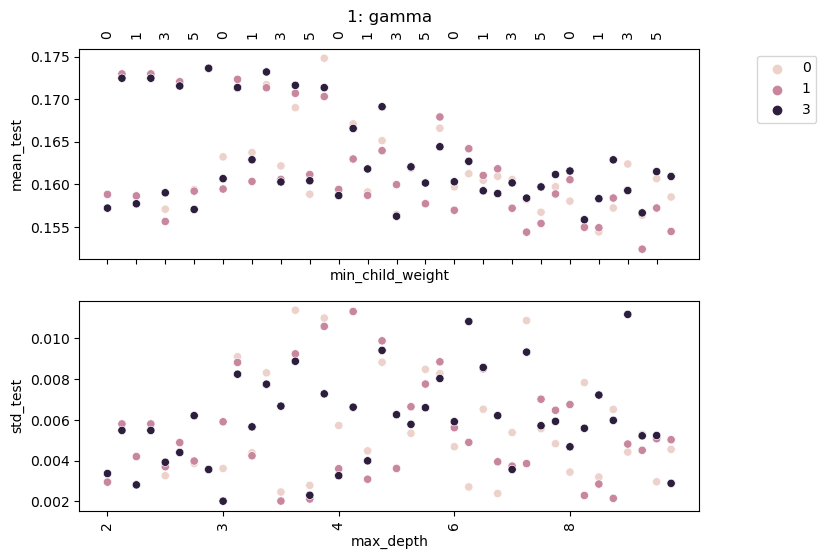

In [28]:
cv_helper.scatterplot('1', hue='gamma', ys=['mean_test','std_test'], x_main='max_depth', x_secondary='min_child_weight')

#### default is gamma=0, min_child_weight=1, depth=6

In [29]:
cv_helper.result_df.sort_values(by='mean_test').head(20).\
        drop(columns=['n_estimators','early_stopping_rounds','learning_rate','eval_metric','id','target'])

,gamma,max_depth,min_child_weight,scale_pos_weight,split_0,split_1,split_2,split_3,mean_test,std_test
77,1,8,3,3.5,0.154639,0.156208,0.144703,0.153942,0.152373,0.004504
69,1,6,3,3.5,0.150895,0.160691,0.154229,0.151665,0.154370,0.003853
34,0,8,1,1.0,0.157895,0.152448,0.150203,0.157068,0.154403,0.003192
79,1,8,5,3.5,0.162304,0.155080,0.148990,0.151439,0.154453,0.005024
74,1,8,1,1.0,0.158184,0.151179,0.153129,0.157068,0.154890,0.002849
73,1,8,0,3.5,0.158311,0.152909,0.152760,0.155779,0.154940,0.002288
33,0,8,0,3.5,0.166441,0.154583,0.144343,0.154534,0.154975,0.007824
70,1,6,5,1.0,0.151432,0.154812,0.166889,0.148438,0.155393,0.007010
44,1,2,3,1.0,0.161644,0.152778,0.152406,0.155673,0.155625,0.003698
113,3,8,0,3.5,0.164659,0.149733,0.152760,0.156171,0.155831,0.005583


In [30]:
param_grid = {'gamma': [0,1],
              'max_depth': [4,6,8,10,12],
              'min_child_weight': [1,3],
              'scale_pos_weight': [3.5],
              'n_estimators': [10000],
              'early_stopping_rounds': [30],
              'learning_rate': [0.1],
              'eval_metric': [f1_eval_error]}

In [31]:
cv_helper = CV_xgboost()
cv_helper.fit(X_train, y_train, param_grid, kf=ShuffleSplit(n_splits=4, random_state=42), verbose=10)

doing {'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'scale_pos_weight': 3.5, 'n_estimators': 10000, 'early_stopping_rounds': 30, 'learning_rate': 0.1, 'eval_metric': <function f1_eval_error at 0x1498d6700>}
[0]	validation_0-logloss:0.63513	validation_0-f1_eval_error:0.24235
[10]	validation_0-logloss:0.36997	validation_0-f1_eval_error:0.20732
[20]	validation_0-logloss:0.29263	validation_0-f1_eval_error:0.19315
[30]	validation_0-logloss:0.26089	validation_0-f1_eval_error:0.18171
[40]	validation_0-logloss:0.24502	validation_0-f1_eval_error:0.17720
[50]	validation_0-logloss:0.23451	validation_0-f1_eval_error:0.17241
[60]	validation_0-logloss:0.22768	validation_0-f1_eval_error:0.16893
[70]	validation_0-logloss:0.22429	validation_0-f1_eval_error:0.16893
[78]	validation_0-logloss:0.22102	validation_0-f1_eval_error:0.16893
[0]	validation_0-logloss:0.63516	validation_0-f1_eval_error:0.22677
[10]	validation_0-logloss:0.36995	validation_0-f1_eval_error:0.20301
[20]	validation_0-logloss:0.29

[120]	validation_0-logloss:0.19763	validation_0-f1_eval_error:0.16046
[130]	validation_0-logloss:0.19746	validation_0-f1_eval_error:0.15871
[140]	validation_0-logloss:0.19742	validation_0-f1_eval_error:0.16021
[150]	validation_0-logloss:0.19678	validation_0-f1_eval_error:0.15979
[152]	validation_0-logloss:0.19667	validation_0-f1_eval_error:0.15979
[0]	validation_0-logloss:0.63027	validation_0-f1_eval_error:0.22087
[10]	validation_0-logloss:0.34783	validation_0-f1_eval_error:0.19240
[20]	validation_0-logloss:0.26987	validation_0-f1_eval_error:0.19029
[30]	validation_0-logloss:0.24131	validation_0-f1_eval_error:0.18205
[40]	validation_0-logloss:0.22912	validation_0-f1_eval_error:0.17738
[50]	validation_0-logloss:0.22271	validation_0-f1_eval_error:0.17783
[60]	validation_0-logloss:0.21948	validation_0-f1_eval_error:0.17419
[70]	validation_0-logloss:0.21644	validation_0-f1_eval_error:0.17161
[80]	validation_0-logloss:0.21515	validation_0-f1_eval_error:0.17419
[90]	validation_0-logloss:0.21

[0]	validation_0-logloss:0.62812	validation_0-f1_eval_error:0.22712
[10]	validation_0-logloss:0.33742	validation_0-f1_eval_error:0.18171
[20]	validation_0-logloss:0.25861	validation_0-f1_eval_error:0.17949
[30]	validation_0-logloss:0.23278	validation_0-f1_eval_error:0.17892
[40]	validation_0-logloss:0.22020	validation_0-f1_eval_error:0.17061
[50]	validation_0-logloss:0.21645	validation_0-f1_eval_error:0.17207
[60]	validation_0-logloss:0.21247	validation_0-f1_eval_error:0.17043
[70]	validation_0-logloss:0.21032	validation_0-f1_eval_error:0.17067
[80]	validation_0-logloss:0.20814	validation_0-f1_eval_error:0.16834
[90]	validation_0-logloss:0.20764	validation_0-f1_eval_error:0.16939
[100]	validation_0-logloss:0.20845	validation_0-f1_eval_error:0.16709
[110]	validation_0-logloss:0.20860	validation_0-f1_eval_error:0.16267
[120]	validation_0-logloss:0.21040	validation_0-f1_eval_error:0.16667
[130]	validation_0-logloss:0.21102	validation_0-f1_eval_error:0.16309
[138]	validation_0-logloss:0.21

[100]	validation_0-logloss:0.21404	validation_0-f1_eval_error:0.14324
[110]	validation_0-logloss:0.21701	validation_0-f1_eval_error:0.14440
[111]	validation_0-logloss:0.21722	validation_0-f1_eval_error:0.14595
[0]	validation_0-logloss:0.62481	validation_0-f1_eval_error:0.20973
[10]	validation_0-logloss:0.32098	validation_0-f1_eval_error:0.17528
[20]	validation_0-logloss:0.23631	validation_0-f1_eval_error:0.17154
[30]	validation_0-logloss:0.20543	validation_0-f1_eval_error:0.16237
[40]	validation_0-logloss:0.19254	validation_0-f1_eval_error:0.15897
[50]	validation_0-logloss:0.18869	validation_0-f1_eval_error:0.15533
[60]	validation_0-logloss:0.18587	validation_0-f1_eval_error:0.15504
[70]	validation_0-logloss:0.18553	validation_0-f1_eval_error:0.16021
[80]	validation_0-logloss:0.18589	validation_0-f1_eval_error:0.15871
[83]	validation_0-logloss:0.18606	validation_0-f1_eval_error:0.15762
[0]	validation_0-logloss:0.62578	validation_0-f1_eval_error:0.22018
[10]	validation_0-logloss:0.32779

[60]	validation_0-logloss:0.22793	validation_0-f1_eval_error:0.16584
[70]	validation_0-logloss:0.22474	validation_0-f1_eval_error:0.17241
[80]	validation_0-logloss:0.22062	validation_0-f1_eval_error:0.16646
[90]	validation_0-logloss:0.21871	validation_0-f1_eval_error:0.17037
[100]	validation_0-logloss:0.21657	validation_0-f1_eval_error:0.16934
[102]	validation_0-logloss:0.21594	validation_0-f1_eval_error:0.17079
[0]	validation_0-logloss:0.63516	validation_0-f1_eval_error:0.22677
[10]	validation_0-logloss:0.36995	validation_0-f1_eval_error:0.20301
[20]	validation_0-logloss:0.29474	validation_0-f1_eval_error:0.20050
[30]	validation_0-logloss:0.26664	validation_0-f1_eval_error:0.18994
[40]	validation_0-logloss:0.25200	validation_0-f1_eval_error:0.18939
[50]	validation_0-logloss:0.24367	validation_0-f1_eval_error:0.18789
[60]	validation_0-logloss:0.23811	validation_0-f1_eval_error:0.17736
[70]	validation_0-logloss:0.23521	validation_0-f1_eval_error:0.18239
[80]	validation_0-logloss:0.23240

[20]	validation_0-logloss:0.25889	validation_0-f1_eval_error:0.17284
[30]	validation_0-logloss:0.22698	validation_0-f1_eval_error:0.15960
[40]	validation_0-logloss:0.21194	validation_0-f1_eval_error:0.15394
[50]	validation_0-logloss:0.20408	validation_0-f1_eval_error:0.15288
[60]	validation_0-logloss:0.20061	validation_0-f1_eval_error:0.15539
[70]	validation_0-logloss:0.19796	validation_0-f1_eval_error:0.14969
[80]	validation_0-logloss:0.19599	validation_0-f1_eval_error:0.15288
[90]	validation_0-logloss:0.19485	validation_0-f1_eval_error:0.15075
[100]	validation_0-logloss:0.19298	validation_0-f1_eval_error:0.15044
[0]	validation_0-logloss:0.63084	validation_0-f1_eval_error:0.21233
[10]	validation_0-logloss:0.35081	validation_0-f1_eval_error:0.19484
[20]	validation_0-logloss:0.27312	validation_0-f1_eval_error:0.18138
[30]	validation_0-logloss:0.24254	validation_0-f1_eval_error:0.17491
[40]	validation_0-logloss:0.22902	validation_0-f1_eval_error:0.16949
[50]	validation_0-logloss:0.22210	

[10]	validation_0-logloss:0.33088	validation_0-f1_eval_error:0.17154
[20]	validation_0-logloss:0.24802	validation_0-f1_eval_error:0.16321
[30]	validation_0-logloss:0.22131	validation_0-f1_eval_error:0.16731
[40]	validation_0-logloss:0.20791	validation_0-f1_eval_error:0.16472
[50]	validation_0-logloss:0.20289	validation_0-f1_eval_error:0.16213
[60]	validation_0-logloss:0.19847	validation_0-f1_eval_error:0.15995
[70]	validation_0-logloss:0.19621	validation_0-f1_eval_error:0.16316
[80]	validation_0-logloss:0.19474	validation_0-f1_eval_error:0.16053
[88]	validation_0-logloss:0.19447	validation_0-f1_eval_error:0.16095
[0]	validation_0-logloss:0.62720	validation_0-f1_eval_error:0.21728
[10]	validation_0-logloss:0.33384	validation_0-f1_eval_error:0.18241
[20]	validation_0-logloss:0.25167	validation_0-f1_eval_error:0.16321
[30]	validation_0-logloss:0.22465	validation_0-f1_eval_error:0.16037
[40]	validation_0-logloss:0.21406	validation_0-f1_eval_error:0.15707
[50]	validation_0-logloss:0.20863	v

[0]	validation_0-logloss:0.62584	validation_0-f1_eval_error:0.22018
[10]	validation_0-logloss:0.32659	validation_0-f1_eval_error:0.17115
[20]	validation_0-logloss:0.24647	validation_0-f1_eval_error:0.17224
[30]	validation_0-logloss:0.22004	validation_0-f1_eval_error:0.16355
[40]	validation_0-logloss:0.20847	validation_0-f1_eval_error:0.16080
[50]	validation_0-logloss:0.20204	validation_0-f1_eval_error:0.15763
[60]	validation_0-logloss:0.19996	validation_0-f1_eval_error:0.15763
[70]	validation_0-logloss:0.19913	validation_0-f1_eval_error:0.15258
[80]	validation_0-logloss:0.19845	validation_0-f1_eval_error:0.15152
[90]	validation_0-logloss:0.19942	validation_0-f1_eval_error:0.15258
[100]	validation_0-logloss:0.20047	validation_0-f1_eval_error:0.15190
[110]	validation_0-logloss:0.20126	validation_0-f1_eval_error:0.15082
[120]	validation_0-logloss:0.20138	validation_0-f1_eval_error:0.15082
[130]	validation_0-logloss:0.20270	validation_0-f1_eval_error:0.15228
[133]	validation_0-logloss:0.20

In [32]:
cv_helper.result_df.sort_values(by='mean_test').head(20).\
        drop(columns=['n_estimators','early_stopping_rounds','learning_rate','eval_metric','id','target'])

,gamma,max_depth,min_child_weight,scale_pos_weight,split_0,split_1,split_2,split_3,mean_test,std_test
7,0,10,3,3.5,0.150466,0.139001,0.152760,0.152284,0.148628,0.005624
6,0,10,1,3.5,0.155080,0.145183,0.145078,0.156962,0.150576,0.005486
14,1,8,1,3.5,0.148437,0.153129,0.149485,0.153359,0.151103,0.002175
19,1,12,3,3.5,0.158177,0.151678,0.141743,0.155499,0.151774,0.006235
15,1,8,3,3.5,0.158442,0.147410,0.141026,0.161290,0.152042,0.008205
8,0,12,1,3.5,0.157470,0.146739,0.149871,0.158428,0.153127,0.004959
18,1,12,1,3.5,0.161725,0.151678,0.145833,0.157088,0.154081,0.005943
17,1,10,3,3.5,0.157199,0.159892,0.149871,0.149367,0.154082,0.004567
9,0,12,3,3.5,0.159686,0.157047,0.145078,0.155216,0.154257,0.005532
16,1,10,1,3.5,0.164219,0.147139,0.153247,0.152971,0.154394,0.006175


In [33]:
# the default ones for gamma and min_child_weight is just fine
best_param = {'gamma': 0,
              'max_depth': 10,
              'min_child_weight': 3,
              'scale_pos_weight': 3.5,
              'n_estimators': 10000,
              'early_stopping_rounds': 50,
              'learning_rate': 0.1,
              'eval_metric': f1_eval_error}

In [34]:
clf = CV_xgboost()
clf.refit(X_train, y_train, best_param, kf=ShuffleSplit(n_splits=4, random_state=42))

[0]	validation_0-logloss:0.62672	validation_0-f1_eval_error:0.24038
[1]	validation_0-logloss:0.57159	validation_0-f1_eval_error:0.20659
[2]	validation_0-logloss:0.52669	validation_0-f1_eval_error:0.19444
[3]	validation_0-logloss:0.48716	validation_0-f1_eval_error:0.19343
[4]	validation_0-logloss:0.45391	validation_0-f1_eval_error:0.18622
[5]	validation_0-logloss:0.42489	validation_0-f1_eval_error:0.17526
[6]	validation_0-logloss:0.40061	validation_0-f1_eval_error:0.18252
[7]	validation_0-logloss:0.37904	validation_0-f1_eval_error:0.18299
[8]	validation_0-logloss:0.35981	validation_0-f1_eval_error:0.18029
[9]	validation_0-logloss:0.34347	validation_0-f1_eval_error:0.18241
[10]	validation_0-logloss:0.32801	validation_0-f1_eval_error:0.18346
[11]	validation_0-logloss:0.31529	validation_0-f1_eval_error:0.18701
[12]	validation_0-logloss:0.30388	validation_0-f1_eval_error:0.18807
[13]	validation_0-logloss:0.29301	validation_0-f1_eval_error:0.18182
[14]	validation_0-logloss:0.28352	validation

[119]	validation_0-logloss:0.20213	validation_0-f1_eval_error:0.15467
[120]	validation_0-logloss:0.20217	validation_0-f1_eval_error:0.15467
[121]	validation_0-logloss:0.20260	validation_0-f1_eval_error:0.15467
[122]	validation_0-logloss:0.20300	validation_0-f1_eval_error:0.15775
[123]	validation_0-logloss:0.20289	validation_0-f1_eval_error:0.15775
[124]	validation_0-logloss:0.20319	validation_0-f1_eval_error:0.15818
[125]	validation_0-logloss:0.20326	validation_0-f1_eval_error:0.15930
[126]	validation_0-logloss:0.20329	validation_0-f1_eval_error:0.15973
[127]	validation_0-logloss:0.20341	validation_0-f1_eval_error:0.15930
[128]	validation_0-logloss:0.20356	validation_0-f1_eval_error:0.16086
[129]	validation_0-logloss:0.20352	validation_0-f1_eval_error:0.15663
[130]	validation_0-logloss:0.20400	validation_0-f1_eval_error:0.16242
[131]	validation_0-logloss:0.20410	validation_0-f1_eval_error:0.15930
[132]	validation_0-logloss:0.20412	validation_0-f1_eval_error:0.15818
[133]	validation_0-l

[11]	validation_0-logloss:0.31408	validation_0-f1_eval_error:0.17585
[12]	validation_0-logloss:0.30187	validation_0-f1_eval_error:0.17632
[13]	validation_0-logloss:0.29162	validation_0-f1_eval_error:0.16931
[14]	validation_0-logloss:0.28319	validation_0-f1_eval_error:0.16556
[15]	validation_0-logloss:0.27534	validation_0-f1_eval_error:0.17021
[16]	validation_0-logloss:0.26798	validation_0-f1_eval_error:0.16755
[17]	validation_0-logloss:0.26068	validation_0-f1_eval_error:0.16600
[18]	validation_0-logloss:0.25521	validation_0-f1_eval_error:0.16821
[19]	validation_0-logloss:0.25002	validation_0-f1_eval_error:0.16600
[20]	validation_0-logloss:0.24510	validation_0-f1_eval_error:0.16291
[21]	validation_0-logloss:0.24078	validation_0-f1_eval_error:0.16402
[22]	validation_0-logloss:0.23740	validation_0-f1_eval_error:0.16223
[23]	validation_0-logloss:0.23307	validation_0-f1_eval_error:0.15957
[24]	validation_0-logloss:0.22997	validation_0-f1_eval_error:0.15538
[25]	validation_0-logloss:0.22742	

[130]	validation_0-logloss:0.22250	validation_0-f1_eval_error:0.14595
[131]	validation_0-logloss:0.22238	validation_0-f1_eval_error:0.14595
[0]	validation_0-logloss:0.62659	validation_0-f1_eval_error:0.23250
[1]	validation_0-logloss:0.57284	validation_0-f1_eval_error:0.22111
[2]	validation_0-logloss:0.52652	validation_0-f1_eval_error:0.20510
[3]	validation_0-logloss:0.48776	validation_0-f1_eval_error:0.19897
[4]	validation_0-logloss:0.45450	validation_0-f1_eval_error:0.19066
[5]	validation_0-logloss:0.42573	validation_0-f1_eval_error:0.19792
[6]	validation_0-logloss:0.39912	validation_0-f1_eval_error:0.18538
[7]	validation_0-logloss:0.37784	validation_0-f1_eval_error:0.18277
[8]	validation_0-logloss:0.35879	validation_0-f1_eval_error:0.18644
[9]	validation_0-logloss:0.34172	validation_0-f1_eval_error:0.17908
[10]	validation_0-logloss:0.32763	validation_0-f1_eval_error:0.18063
[11]	validation_0-logloss:0.31408	validation_0-f1_eval_error:0.17585
[12]	validation_0-logloss:0.30187	validati

[34]	validation_0-logloss:0.19955	validation_0-f1_eval_error:0.15790
[35]	validation_0-logloss:0.19805	validation_0-f1_eval_error:0.16195
[36]	validation_0-logloss:0.19613	validation_0-f1_eval_error:0.16046
[37]	validation_0-logloss:0.19502	validation_0-f1_eval_error:0.15749
[38]	validation_0-logloss:0.19434	validation_0-f1_eval_error:0.16112
[39]	validation_0-logloss:0.19343	validation_0-f1_eval_error:0.16005
[40]	validation_0-logloss:0.19254	validation_0-f1_eval_error:0.15897
[41]	validation_0-logloss:0.19219	validation_0-f1_eval_error:0.15857
[42]	validation_0-logloss:0.19160	validation_0-f1_eval_error:0.16005
[43]	validation_0-logloss:0.19081	validation_0-f1_eval_error:0.15790
[44]	validation_0-logloss:0.19055	validation_0-f1_eval_error:0.15641
[45]	validation_0-logloss:0.18997	validation_0-f1_eval_error:0.15749
[46]	validation_0-logloss:0.18975	validation_0-f1_eval_error:0.15749
[47]	validation_0-logloss:0.18964	validation_0-f1_eval_error:0.15681
[48]	validation_0-logloss:0.18965	

[48]	validation_0-logloss:0.18965	validation_0-f1_eval_error:0.15573
[49]	validation_0-logloss:0.18913	validation_0-f1_eval_error:0.15790
[50]	validation_0-logloss:0.18869	validation_0-f1_eval_error:0.15533
[51]	validation_0-logloss:0.18829	validation_0-f1_eval_error:0.15681
[52]	validation_0-logloss:0.18801	validation_0-f1_eval_error:0.15533
[53]	validation_0-logloss:0.18814	validation_0-f1_eval_error:0.15573
[54]	validation_0-logloss:0.18808	validation_0-f1_eval_error:0.15276
[0]	validation_0-logloss:0.62578	validation_0-f1_eval_error:0.22018
[1]	validation_0-logloss:0.57085	validation_0-f1_eval_error:0.18430
[2]	validation_0-logloss:0.52426	validation_0-f1_eval_error:0.18483
[3]	validation_0-logloss:0.48560	validation_0-f1_eval_error:0.18510
[4]	validation_0-logloss:0.45170	validation_0-f1_eval_error:0.18357
[5]	validation_0-logloss:0.42405	validation_0-f1_eval_error:0.18116
[6]	validation_0-logloss:0.39965	validation_0-f1_eval_error:0.17788
[7]	validation_0-logloss:0.37760	validati

[112]	validation_0-logloss:0.20506	validation_0-f1_eval_error:0.15453
[113]	validation_0-logloss:0.20534	validation_0-f1_eval_error:0.15561
[114]	validation_0-logloss:0.20547	validation_0-f1_eval_error:0.15414
[115]	validation_0-logloss:0.20586	validation_0-f1_eval_error:0.15669
[116]	validation_0-logloss:0.20612	validation_0-f1_eval_error:0.15669
[117]	validation_0-logloss:0.20632	validation_0-f1_eval_error:0.15669
[118]	validation_0-logloss:0.20651	validation_0-f1_eval_error:0.15561
[119]	validation_0-logloss:0.20677	validation_0-f1_eval_error:0.15709
[120]	validation_0-logloss:0.20695	validation_0-f1_eval_error:0.15816
[121]	validation_0-logloss:0.20695	validation_0-f1_eval_error:0.15709
[122]	validation_0-logloss:0.20708	validation_0-f1_eval_error:0.15964
[123]	validation_0-logloss:0.20732	validation_0-f1_eval_error:0.15816
[124]	validation_0-logloss:0.20760	validation_0-f1_eval_error:0.15964
[125]	validation_0-logloss:0.20804	validation_0-f1_eval_error:0.15776
[126]	validation_0-l

[90]	validation_0-logloss:0.20145	validation_0-f1_eval_error:0.15297
[91]	validation_0-logloss:0.20194	validation_0-f1_eval_error:0.15228


In [35]:
f1_score(clf.predict(X_test), y_test)

0.8538767395626242

In [36]:
for i in range(4):
    print(f1_score(clf.clfs[i].predict(X_test), y_test))

0.854320987654321
0.8553022794846382
0.8472906403940886
0.8516699410609037


In [37]:
with open('xgboost_no_state.pickle', 'wb') as fid:
    pickle.dump(clf, fid)

### 5. let's see if stacking can reduce the error

In [38]:
with open('random_forest_no_state.pickle', 'rb') as fid:
    clf_rf = pickle.load(fid)
with open('logistic_regression_no_state.pickle', 'rb') as fid:
    clf_lr = pickle.load(fid)
with open('svm_no_state.pickle', 'rb') as fid:
    clf_svm = pickle.load(fid)
with open('xgboost_no_state.pickle', 'rb') as fid:
    clf_xgb = pickle.load(fid)

### 5.1 simple avg

In [39]:
clfs = [clf_rf, clf_lr, clf_svm, clf_xgb]
for iclf, clf in enumerate(clfs):
    print(iclf)
    if iclf == 0:
        p = clf.predict_proba(X_test)
    else:
        p = p + clf.predict_proba(X_test)
p = p / len(clfs)
y_pred = np.where(p[:,1]>0.5, 1.0, 0.0)

0
1
2
3


In [40]:
f1_score(y_pred, y_test)

0.8468992248062015

### 5.2 voting

In [41]:
clfs = [clf_rf, clf_lr, clf_svm, clf_xgb]
for iclf, clf in enumerate(clfs):
    print(iclf)
    if iclf == 0:
        p = clf.predict(X_test)
    else:
        p = p + clf.predict(X_test)
y_pred = np.where(p>2, 1.0, 0.0)
f1_score(y_pred, y_test)

0
1
2
3


0.857566765578635

### 5.3 Generate probabilities from each model then use logistic regression as the stacking model

In [42]:
from sklearn.base import clone

In [43]:
class Stacker(CVResultAnalyzer):
    def __init__(self, clfs, clf_stack=LogisticRegression(class_weight='balanced'), score=f1_score):
        self.clfs = clfs
        self.clf_stack = clf_stack
        self.score = score
    
    def fit(self, X, y, param_grid, kf=StratifiedKFold(n_splits=4), target='1'):
        ''' do some cv on param_grid '''
        cols = defaultdict(list)
        param_names, param_vals = list(zip(*param_grid.items()))
        
        # loop over isplit
        for isplit, (train_idx, test_idx) in enumerate(kf.split(X, y)):
            print(f"doing split: {isplit}")
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            # refit each clf and assemble the probs for this split
            for iclf, clf in enumerate(self.clfs):
                print(f"doing: {clf}")
                if isinstance(clf, CV_xgboost):
                    clf_tmp = deepcopy(clf)
                    best_params = clf_tmp.clfs[0].get_params()
                    print(best_params)
                    best_params.pop('objective')
                    clf_tmp.refit(X_train, y_train, best_params)
                else:
                    clf_tmp = clone(clf)
                    clf_tmp.fit(X_train, y_train)
                if iclf == 0:
                    p_train = clf_tmp.predict_proba(X_train)[:,1].reshape(-1,1)
                    p_test = clf_tmp.predict_proba(X_test)[:,1].reshape(-1,1)
                else:
                    p_train = np.hstack([p_train, clf_tmp.predict_proba(X_train)[:,1].reshape(-1,1)])
                    p_test = np.hstack([p_test, clf_tmp.predict_proba(X_test)[:,1].reshape(-1,1)])
 
            # loop over param for the stacker
            for param_val in product(*param_vals):
                param = dict(zip(param_names, param_val))
                clf_stack = clone(self.clf_stack)
                clf_stack.set_params(**param)
                print(clf_stack)
                
                # record the param in the first split
                if isplit == 0:
                    for k, v in param.items():
                        cols[k].append(v)
               
                # fit the clf_stack and record the score
                clf_stack.fit(p_train, y_train)
                cols[f"split_{isplit}"].append(self.score(clf_stack.predict(p_test), y_test))
        
        # assemble the result_df
        self.result_df = pd.DataFrame.from_dict(cols)
        self.result_df['target'] = target        
        self.result_df.reset_index(names=['id'], inplace=True) # this is useful in scatterplot
        cols_splits = [f"split_{isplit}" for isplit in range(kf.get_n_splits())]
        self.result_df['mean_test'] = self.result_df[cols_splits].mean(axis=1)
        self.result_df['std_test'] = self.result_df[cols_splits].std(axis=1)
    
    
    def _get_proba(self, X):
        for iclf, clf in enumerate(self.clfs):
            if iclf == 0:
                p = clf.predict_proba(X)[:,1].reshape(-1,1)
            else:
                p = np.hstack([p, clf.predict_proba(X)[:,1].reshape(-1,1)])
        return p
    
    def refit(self, X, y, best_param):
        p = self._get_proba(X)
        self.clf_stack.set_params(**best_param)
        self.clf_stack.fit(p, y)
    
    def predict_proba(self, X):
        p = self._get_proba(X)
        return sefl.clf_stack.predict_proba(p)
    
    def predict(self, X):
        p = self._get_proba(X)
        return self.clf_stack.predict(p)

In [44]:
stacker = Stacker(clfs)

In [45]:
param_grid = {'C':[1e-4,5e-4,1e-3,5e-3,1e-2,1e-1,1.0,5.0,10.0,20.0,50.0,70.0,100.0]}
stacker.fit(X_train, y_train, param_grid, kf=ShuffleSplit(n_splits=4, random_state=42))

doing split: 0
doing: RandomForestClassifier(class_weight='balanced', min_samples_leaf=6,
                       random_state=42)
doing: Pipeline(steps=[('preprocess', PowerTransformer()),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=10000))])
doing: Pipeline(steps=[('preprocess', PowerTransformer()),
                ('clf', SVC(C=0.7, class_weight='balanced', probability=True))])
doing: <__main__.CV_xgboost object at 0x14544bc10>
{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': 50, 'enable_categorical': False, 'eval_metric': <function f1_eval_error at 0x1498d6700>, 'feature_types': None, 'gamma': 0, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': N

[98]	validation_0-logloss:0.19571	validation_0-f1_eval_error:0.15519
[99]	validation_0-logloss:0.19566	validation_0-f1_eval_error:0.15568
[100]	validation_0-logloss:0.19567	validation_0-f1_eval_error:0.15537
[101]	validation_0-logloss:0.19581	validation_0-f1_eval_error:0.15654
[102]	validation_0-logloss:0.19589	validation_0-f1_eval_error:0.15654
[103]	validation_0-logloss:0.19608	validation_0-f1_eval_error:0.15771
[104]	validation_0-logloss:0.19627	validation_0-f1_eval_error:0.15537
[105]	validation_0-logloss:0.19618	validation_0-f1_eval_error:0.15519
[106]	validation_0-logloss:0.19650	validation_0-f1_eval_error:0.15568
[107]	validation_0-logloss:0.19654	validation_0-f1_eval_error:0.15771
[108]	validation_0-logloss:0.19680	validation_0-f1_eval_error:0.15654
[109]	validation_0-logloss:0.19702	validation_0-f1_eval_error:0.15654
[110]	validation_0-logloss:0.19727	validation_0-f1_eval_error:0.15654
[111]	validation_0-logloss:0.19769	validation_0-f1_eval_error:0.15556
[112]	validation_0-log

[24]	validation_0-logloss:0.23642	validation_0-f1_eval_error:0.17931
[25]	validation_0-logloss:0.23367	validation_0-f1_eval_error:0.17904
[26]	validation_0-logloss:0.23183	validation_0-f1_eval_error:0.17925
[27]	validation_0-logloss:0.23002	validation_0-f1_eval_error:0.17762
[28]	validation_0-logloss:0.22820	validation_0-f1_eval_error:0.17735
[29]	validation_0-logloss:0.22660	validation_0-f1_eval_error:0.17878
[30]	validation_0-logloss:0.22522	validation_0-f1_eval_error:0.17898
[31]	validation_0-logloss:0.22389	validation_0-f1_eval_error:0.18082
[32]	validation_0-logloss:0.22283	validation_0-f1_eval_error:0.17961
[33]	validation_0-logloss:0.22173	validation_0-f1_eval_error:0.18008
[34]	validation_0-logloss:0.22101	validation_0-f1_eval_error:0.17777
[35]	validation_0-logloss:0.22009	validation_0-f1_eval_error:0.17845
[36]	validation_0-logloss:0.21947	validation_0-f1_eval_error:0.17729
[37]	validation_0-logloss:0.21889	validation_0-f1_eval_error:0.17845
[38]	validation_0-logloss:0.21806	

[5]	validation_0-logloss:0.42666	validation_0-f1_eval_error:0.19776
[6]	validation_0-logloss:0.40231	validation_0-f1_eval_error:0.19551
[7]	validation_0-logloss:0.38090	validation_0-f1_eval_error:0.19662
[8]	validation_0-logloss:0.36177	validation_0-f1_eval_error:0.19456
[9]	validation_0-logloss:0.34500	validation_0-f1_eval_error:0.19773
[10]	validation_0-logloss:0.33022	validation_0-f1_eval_error:0.19298
[11]	validation_0-logloss:0.31786	validation_0-f1_eval_error:0.19159
[12]	validation_0-logloss:0.30614	validation_0-f1_eval_error:0.19180
[13]	validation_0-logloss:0.29588	validation_0-f1_eval_error:0.19067
[14]	validation_0-logloss:0.28686	validation_0-f1_eval_error:0.19018
[15]	validation_0-logloss:0.27887	validation_0-f1_eval_error:0.18900
[16]	validation_0-logloss:0.27138	validation_0-f1_eval_error:0.18879
[17]	validation_0-logloss:0.26449	validation_0-f1_eval_error:0.18553
[18]	validation_0-logloss:0.25907	validation_0-f1_eval_error:0.18854
[19]	validation_0-logloss:0.25420	valid

[36]	validation_0-logloss:0.21034	validation_0-f1_eval_error:0.17341
[37]	validation_0-logloss:0.20948	validation_0-f1_eval_error:0.17341
[38]	validation_0-logloss:0.20906	validation_0-f1_eval_error:0.17321
[39]	validation_0-logloss:0.20827	validation_0-f1_eval_error:0.17138
[40]	validation_0-logloss:0.20762	validation_0-f1_eval_error:0.17110
[41]	validation_0-logloss:0.20697	validation_0-f1_eval_error:0.17178
[42]	validation_0-logloss:0.20655	validation_0-f1_eval_error:0.17341
[43]	validation_0-logloss:0.20652	validation_0-f1_eval_error:0.17110
[44]	validation_0-logloss:0.20661	validation_0-f1_eval_error:0.17206
[45]	validation_0-logloss:0.20634	validation_0-f1_eval_error:0.17110
[46]	validation_0-logloss:0.20636	validation_0-f1_eval_error:0.17178
[47]	validation_0-logloss:0.20597	validation_0-f1_eval_error:0.17082
[48]	validation_0-logloss:0.20569	validation_0-f1_eval_error:0.17178
[49]	validation_0-logloss:0.20576	validation_0-f1_eval_error:0.17062
[50]	validation_0-logloss:0.20573	

[15]	validation_0-logloss:0.27361	validation_0-f1_eval_error:0.18156
[16]	validation_0-logloss:0.26600	validation_0-f1_eval_error:0.17922
[17]	validation_0-logloss:0.25925	validation_0-f1_eval_error:0.17875
[18]	validation_0-logloss:0.25343	validation_0-f1_eval_error:0.17782
[19]	validation_0-logloss:0.24831	validation_0-f1_eval_error:0.17943
[20]	validation_0-logloss:0.24353	validation_0-f1_eval_error:0.17869
[21]	validation_0-logloss:0.23885	validation_0-f1_eval_error:0.17775
[22]	validation_0-logloss:0.23505	validation_0-f1_eval_error:0.17748
[23]	validation_0-logloss:0.23220	validation_0-f1_eval_error:0.17566
[24]	validation_0-logloss:0.22896	validation_0-f1_eval_error:0.17586
[25]	validation_0-logloss:0.22604	validation_0-f1_eval_error:0.17309
[26]	validation_0-logloss:0.22361	validation_0-f1_eval_error:0.17539
[27]	validation_0-logloss:0.22183	validation_0-f1_eval_error:0.17158
[28]	validation_0-logloss:0.21982	validation_0-f1_eval_error:0.17301
[29]	validation_0-logloss:0.21815	

[44]	validation_0-logloss:0.20794	validation_0-f1_eval_error:0.17654
[45]	validation_0-logloss:0.20778	validation_0-f1_eval_error:0.17462
[46]	validation_0-logloss:0.20749	validation_0-f1_eval_error:0.17442
[47]	validation_0-logloss:0.20710	validation_0-f1_eval_error:0.17462
[48]	validation_0-logloss:0.20723	validation_0-f1_eval_error:0.17374
[49]	validation_0-logloss:0.20671	validation_0-f1_eval_error:0.17490
[50]	validation_0-logloss:0.20683	validation_0-f1_eval_error:0.17257
[51]	validation_0-logloss:0.20672	validation_0-f1_eval_error:0.17599
[52]	validation_0-logloss:0.20699	validation_0-f1_eval_error:0.17572
[53]	validation_0-logloss:0.20703	validation_0-f1_eval_error:0.17763
[54]	validation_0-logloss:0.20689	validation_0-f1_eval_error:0.17949
[55]	validation_0-logloss:0.20697	validation_0-f1_eval_error:0.17955
[56]	validation_0-logloss:0.20688	validation_0-f1_eval_error:0.17880
[57]	validation_0-logloss:0.20690	validation_0-f1_eval_error:0.17763
[58]	validation_0-logloss:0.20695	

[162]	validation_0-logloss:0.22558	validation_0-f1_eval_error:0.16979
[163]	validation_0-logloss:0.22568	validation_0-f1_eval_error:0.16979
[164]	validation_0-logloss:0.22590	validation_0-f1_eval_error:0.17096
[165]	validation_0-logloss:0.22624	validation_0-f1_eval_error:0.16979
[166]	validation_0-logloss:0.22642	validation_0-f1_eval_error:0.16979
[167]	validation_0-logloss:0.22669	validation_0-f1_eval_error:0.16979
[168]	validation_0-logloss:0.22685	validation_0-f1_eval_error:0.17116
[169]	validation_0-logloss:0.22714	validation_0-f1_eval_error:0.16999
[170]	validation_0-logloss:0.22746	validation_0-f1_eval_error:0.17136
[171]	validation_0-logloss:0.22775	validation_0-f1_eval_error:0.17136
[172]	validation_0-logloss:0.22798	validation_0-f1_eval_error:0.17233
[173]	validation_0-logloss:0.22811	validation_0-f1_eval_error:0.17233
[174]	validation_0-logloss:0.22850	validation_0-f1_eval_error:0.17233
[175]	validation_0-logloss:0.22887	validation_0-f1_eval_error:0.17233
[176]	validation_0-l

[76]	validation_0-logloss:0.20840	validation_0-f1_eval_error:0.17681
[77]	validation_0-logloss:0.20850	validation_0-f1_eval_error:0.17681
[78]	validation_0-logloss:0.20880	validation_0-f1_eval_error:0.17661
[79]	validation_0-logloss:0.20876	validation_0-f1_eval_error:0.17778
[80]	validation_0-logloss:0.20889	validation_0-f1_eval_error:0.17585
[81]	validation_0-logloss:0.20877	validation_0-f1_eval_error:0.17564
[82]	validation_0-logloss:0.20877	validation_0-f1_eval_error:0.17564
[83]	validation_0-logloss:0.20837	validation_0-f1_eval_error:0.17496
[84]	validation_0-logloss:0.20875	validation_0-f1_eval_error:0.17613
[85]	validation_0-logloss:0.20905	validation_0-f1_eval_error:0.17516
[86]	validation_0-logloss:0.20935	validation_0-f1_eval_error:0.17564
[87]	validation_0-logloss:0.20954	validation_0-f1_eval_error:0.17496
[88]	validation_0-logloss:0.20970	validation_0-f1_eval_error:0.17447
[89]	validation_0-logloss:0.20974	validation_0-f1_eval_error:0.17468
[90]	validation_0-logloss:0.20967	

[7]	validation_0-logloss:0.37964	validation_0-f1_eval_error:0.18833
[8]	validation_0-logloss:0.35992	validation_0-f1_eval_error:0.18743
[9]	validation_0-logloss:0.34301	validation_0-f1_eval_error:0.18347
[10]	validation_0-logloss:0.32786	validation_0-f1_eval_error:0.18453
[11]	validation_0-logloss:0.31452	validation_0-f1_eval_error:0.17915
[12]	validation_0-logloss:0.30270	validation_0-f1_eval_error:0.17647
[13]	validation_0-logloss:0.29222	validation_0-f1_eval_error:0.17503
[14]	validation_0-logloss:0.28354	validation_0-f1_eval_error:0.17299
[15]	validation_0-logloss:0.27538	validation_0-f1_eval_error:0.17535
[16]	validation_0-logloss:0.26801	validation_0-f1_eval_error:0.17330
[17]	validation_0-logloss:0.26195	validation_0-f1_eval_error:0.17462
[18]	validation_0-logloss:0.25643	validation_0-f1_eval_error:0.17574
[19]	validation_0-logloss:0.25159	validation_0-f1_eval_error:0.17660
[20]	validation_0-logloss:0.24683	validation_0-f1_eval_error:0.17660
[21]	validation_0-logloss:0.24219	val

[12]	validation_0-logloss:0.30270	validation_0-f1_eval_error:0.17647
[13]	validation_0-logloss:0.29222	validation_0-f1_eval_error:0.17503
[14]	validation_0-logloss:0.28354	validation_0-f1_eval_error:0.17299
[15]	validation_0-logloss:0.27538	validation_0-f1_eval_error:0.17535
[16]	validation_0-logloss:0.26801	validation_0-f1_eval_error:0.17330
[17]	validation_0-logloss:0.26195	validation_0-f1_eval_error:0.17462
[18]	validation_0-logloss:0.25643	validation_0-f1_eval_error:0.17574
[19]	validation_0-logloss:0.25159	validation_0-f1_eval_error:0.17660
[20]	validation_0-logloss:0.24683	validation_0-f1_eval_error:0.17660
[21]	validation_0-logloss:0.24219	validation_0-f1_eval_error:0.17727
[22]	validation_0-logloss:0.23812	validation_0-f1_eval_error:0.17501
[23]	validation_0-logloss:0.23484	validation_0-f1_eval_error:0.17323
[24]	validation_0-logloss:0.23183	validation_0-f1_eval_error:0.17230
[25]	validation_0-logloss:0.22889	validation_0-f1_eval_error:0.17241
[26]	validation_0-logloss:0.22687	

[66]	validation_0-logloss:0.20108	validation_0-f1_eval_error:0.16260
[67]	validation_0-logloss:0.20119	validation_0-f1_eval_error:0.16376
[68]	validation_0-logloss:0.20085	validation_0-f1_eval_error:0.16241
[69]	validation_0-logloss:0.20137	validation_0-f1_eval_error:0.16579
[70]	validation_0-logloss:0.20151	validation_0-f1_eval_error:0.16444
[71]	validation_0-logloss:0.20168	validation_0-f1_eval_error:0.16444
[72]	validation_0-logloss:0.20215	validation_0-f1_eval_error:0.16444
[73]	validation_0-logloss:0.20235	validation_0-f1_eval_error:0.16512
[74]	validation_0-logloss:0.20197	validation_0-f1_eval_error:0.16444
[75]	validation_0-logloss:0.20240	validation_0-f1_eval_error:0.16444
[76]	validation_0-logloss:0.20255	validation_0-f1_eval_error:0.16512
[77]	validation_0-logloss:0.20274	validation_0-f1_eval_error:0.16560
[78]	validation_0-logloss:0.20282	validation_0-f1_eval_error:0.16512
[79]	validation_0-logloss:0.20293	validation_0-f1_eval_error:0.16579
[80]	validation_0-logloss:0.20278	

[61]	validation_0-logloss:0.20684	validation_0-f1_eval_error:0.17784
[62]	validation_0-logloss:0.20664	validation_0-f1_eval_error:0.17736
[63]	validation_0-logloss:0.20679	validation_0-f1_eval_error:0.17805
[64]	validation_0-logloss:0.20702	validation_0-f1_eval_error:0.17688
[65]	validation_0-logloss:0.20703	validation_0-f1_eval_error:0.17757
[66]	validation_0-logloss:0.20719	validation_0-f1_eval_error:0.17805
[67]	validation_0-logloss:0.20669	validation_0-f1_eval_error:0.17757
[68]	validation_0-logloss:0.20696	validation_0-f1_eval_error:0.17778
[69]	validation_0-logloss:0.20694	validation_0-f1_eval_error:0.17778
[70]	validation_0-logloss:0.20720	validation_0-f1_eval_error:0.17709
[71]	validation_0-logloss:0.20726	validation_0-f1_eval_error:0.17681
[72]	validation_0-logloss:0.20743	validation_0-f1_eval_error:0.17633
[73]	validation_0-logloss:0.20711	validation_0-f1_eval_error:0.17585
[74]	validation_0-logloss:0.20763	validation_0-f1_eval_error:0.17633
[75]	validation_0-logloss:0.20791	

[24]	validation_0-logloss:0.23387	validation_0-f1_eval_error:0.18916
[25]	validation_0-logloss:0.23130	validation_0-f1_eval_error:0.18707
[26]	validation_0-logloss:0.22862	validation_0-f1_eval_error:0.18497
[27]	validation_0-logloss:0.22686	validation_0-f1_eval_error:0.18609
[28]	validation_0-logloss:0.22472	validation_0-f1_eval_error:0.18728
[29]	validation_0-logloss:0.22303	validation_0-f1_eval_error:0.18681
[30]	validation_0-logloss:0.22172	validation_0-f1_eval_error:0.18866
[31]	validation_0-logloss:0.22003	validation_0-f1_eval_error:0.19031
[32]	validation_0-logloss:0.21829	validation_0-f1_eval_error:0.18844
[33]	validation_0-logloss:0.21663	validation_0-f1_eval_error:0.18591
[34]	validation_0-logloss:0.21578	validation_0-f1_eval_error:0.18570
[35]	validation_0-logloss:0.21466	validation_0-f1_eval_error:0.18638
[36]	validation_0-logloss:0.21372	validation_0-f1_eval_error:0.18566
[37]	validation_0-logloss:0.21251	validation_0-f1_eval_error:0.18424
[38]	validation_0-logloss:0.21215	

[37]	validation_0-logloss:0.21586	validation_0-f1_eval_error:0.17816
[38]	validation_0-logloss:0.21482	validation_0-f1_eval_error:0.17674
[39]	validation_0-logloss:0.21423	validation_0-f1_eval_error:0.17742
[40]	validation_0-logloss:0.21388	validation_0-f1_eval_error:0.17627
[41]	validation_0-logloss:0.21333	validation_0-f1_eval_error:0.17647
[42]	validation_0-logloss:0.21277	validation_0-f1_eval_error:0.17579
[43]	validation_0-logloss:0.21236	validation_0-f1_eval_error:0.17504
[44]	validation_0-logloss:0.21198	validation_0-f1_eval_error:0.17409
[45]	validation_0-logloss:0.21182	validation_0-f1_eval_error:0.17661
[46]	validation_0-logloss:0.21172	validation_0-f1_eval_error:0.17545
[47]	validation_0-logloss:0.21162	validation_0-f1_eval_error:0.17593
[48]	validation_0-logloss:0.21144	validation_0-f1_eval_error:0.17735
[49]	validation_0-logloss:0.21137	validation_0-f1_eval_error:0.17504
[50]	validation_0-logloss:0.21108	validation_0-f1_eval_error:0.17409
[51]	validation_0-logloss:0.21062	

[155]	validation_0-logloss:0.22443	validation_0-f1_eval_error:0.16988
[156]	validation_0-logloss:0.22434	validation_0-f1_eval_error:0.16988
[157]	validation_0-logloss:0.22448	validation_0-f1_eval_error:0.16988
[158]	validation_0-logloss:0.22474	validation_0-f1_eval_error:0.16871
[159]	validation_0-logloss:0.22508	validation_0-f1_eval_error:0.17036
[160]	validation_0-logloss:0.22543	validation_0-f1_eval_error:0.16968
[161]	validation_0-logloss:0.22560	validation_0-f1_eval_error:0.16968
[162]	validation_0-logloss:0.22594	validation_0-f1_eval_error:0.16920
[163]	validation_0-logloss:0.22613	validation_0-f1_eval_error:0.16988
[164]	validation_0-logloss:0.22634	validation_0-f1_eval_error:0.16871
[165]	validation_0-logloss:0.22664	validation_0-f1_eval_error:0.17036
[166]	validation_0-logloss:0.22672	validation_0-f1_eval_error:0.17036
[167]	validation_0-logloss:0.22675	validation_0-f1_eval_error:0.16920
[168]	validation_0-logloss:0.22682	validation_0-f1_eval_error:0.16754
[169]	validation_0-l

[18]	validation_0-logloss:0.25809	validation_0-f1_eval_error:0.18493
[19]	validation_0-logloss:0.25310	validation_0-f1_eval_error:0.18197
[20]	validation_0-logloss:0.24876	validation_0-f1_eval_error:0.18083
[21]	validation_0-logloss:0.24490	validation_0-f1_eval_error:0.18125
[22]	validation_0-logloss:0.24114	validation_0-f1_eval_error:0.18125
[23]	validation_0-logloss:0.23797	validation_0-f1_eval_error:0.18031
[24]	validation_0-logloss:0.23503	validation_0-f1_eval_error:0.18031
[25]	validation_0-logloss:0.23273	validation_0-f1_eval_error:0.18057
[26]	validation_0-logloss:0.23013	validation_0-f1_eval_error:0.17896
[27]	validation_0-logloss:0.22789	validation_0-f1_eval_error:0.17916
[28]	validation_0-logloss:0.22615	validation_0-f1_eval_error:0.18057
[29]	validation_0-logloss:0.22456	validation_0-f1_eval_error:0.17829
[30]	validation_0-logloss:0.22310	validation_0-f1_eval_error:0.18052
[31]	validation_0-logloss:0.22177	validation_0-f1_eval_error:0.17843
[32]	validation_0-logloss:0.22050	

[137]	validation_0-logloss:0.22230	validation_0-f1_eval_error:0.16871
[138]	validation_0-logloss:0.22248	validation_0-f1_eval_error:0.16871
[139]	validation_0-logloss:0.22239	validation_0-f1_eval_error:0.16871
[140]	validation_0-logloss:0.22258	validation_0-f1_eval_error:0.16988
[141]	validation_0-logloss:0.22265	validation_0-f1_eval_error:0.17056
[142]	validation_0-logloss:0.22267	validation_0-f1_eval_error:0.16939
[143]	validation_0-logloss:0.22283	validation_0-f1_eval_error:0.16988
[144]	validation_0-logloss:0.22293	validation_0-f1_eval_error:0.16959
[145]	validation_0-logloss:0.22295	validation_0-f1_eval_error:0.16891
[146]	validation_0-logloss:0.22264	validation_0-f1_eval_error:0.16939
[147]	validation_0-logloss:0.22300	validation_0-f1_eval_error:0.16939
[148]	validation_0-logloss:0.22329	validation_0-f1_eval_error:0.17036
[149]	validation_0-logloss:0.22335	validation_0-f1_eval_error:0.17036
[150]	validation_0-logloss:0.22336	validation_0-f1_eval_error:0.17036
[151]	validation_0-l

[19]	validation_0-logloss:0.25632	validation_0-f1_eval_error:0.18829
[20]	validation_0-logloss:0.25147	validation_0-f1_eval_error:0.18779
[21]	validation_0-logloss:0.24663	validation_0-f1_eval_error:0.18407
[22]	validation_0-logloss:0.24280	validation_0-f1_eval_error:0.18407
[23]	validation_0-logloss:0.23897	validation_0-f1_eval_error:0.18450
[24]	validation_0-logloss:0.23544	validation_0-f1_eval_error:0.18591
[25]	validation_0-logloss:0.23256	validation_0-f1_eval_error:0.18355
[26]	validation_0-logloss:0.22945	validation_0-f1_eval_error:0.18355
[27]	validation_0-logloss:0.22667	validation_0-f1_eval_error:0.18029
[28]	validation_0-logloss:0.22415	validation_0-f1_eval_error:0.18050
[29]	validation_0-logloss:0.22241	validation_0-f1_eval_error:0.17907
[30]	validation_0-logloss:0.22057	validation_0-f1_eval_error:0.17886
[31]	validation_0-logloss:0.21937	validation_0-f1_eval_error:0.17838
[32]	validation_0-logloss:0.21757	validation_0-f1_eval_error:0.17955
[33]	validation_0-logloss:0.21606	

[138]	validation_0-logloss:0.21832	validation_0-f1_eval_error:0.16834
[139]	validation_0-logloss:0.21845	validation_0-f1_eval_error:0.16785
[140]	validation_0-logloss:0.21866	validation_0-f1_eval_error:0.16667
[141]	validation_0-logloss:0.21871	validation_0-f1_eval_error:0.16736
[142]	validation_0-logloss:0.21879	validation_0-f1_eval_error:0.16637
[143]	validation_0-logloss:0.21878	validation_0-f1_eval_error:0.16548
[144]	validation_0-logloss:0.21905	validation_0-f1_eval_error:0.16430
[145]	validation_0-logloss:0.21920	validation_0-f1_eval_error:0.16430
[146]	validation_0-logloss:0.21968	validation_0-f1_eval_error:0.16499
[147]	validation_0-logloss:0.22010	validation_0-f1_eval_error:0.16568
[148]	validation_0-logloss:0.22022	validation_0-f1_eval_error:0.16430
[149]	validation_0-logloss:0.22032	validation_0-f1_eval_error:0.16499
[150]	validation_0-logloss:0.22054	validation_0-f1_eval_error:0.16499
[151]	validation_0-logloss:0.22087	validation_0-f1_eval_error:0.16450
[152]	validation_0-l

[101]	validation_0-logloss:0.21111	validation_0-f1_eval_error:0.16617
[102]	validation_0-logloss:0.21147	validation_0-f1_eval_error:0.16736
[103]	validation_0-logloss:0.21164	validation_0-f1_eval_error:0.16617
[104]	validation_0-logloss:0.21203	validation_0-f1_eval_error:0.16637
[105]	validation_0-logloss:0.21220	validation_0-f1_eval_error:0.16519
[106]	validation_0-logloss:0.21243	validation_0-f1_eval_error:0.16381
[0]	validation_0-logloss:0.62742	validation_0-f1_eval_error:0.25132
[1]	validation_0-logloss:0.57386	validation_0-f1_eval_error:0.22747
[2]	validation_0-logloss:0.52766	validation_0-f1_eval_error:0.21806
[3]	validation_0-logloss:0.48939	validation_0-f1_eval_error:0.21623
[4]	validation_0-logloss:0.45665	validation_0-f1_eval_error:0.21242
[5]	validation_0-logloss:0.42849	validation_0-f1_eval_error:0.21226
[6]	validation_0-logloss:0.40432	validation_0-f1_eval_error:0.21141
[7]	validation_0-logloss:0.38309	validation_0-f1_eval_error:0.20831
[8]	validation_0-logloss:0.36456	val

[113]	validation_0-logloss:0.23949	validation_0-f1_eval_error:0.17286
[114]	validation_0-logloss:0.23995	validation_0-f1_eval_error:0.17286
[115]	validation_0-logloss:0.24034	validation_0-f1_eval_error:0.17355
[116]	validation_0-logloss:0.24100	validation_0-f1_eval_error:0.17307
[117]	validation_0-logloss:0.24145	validation_0-f1_eval_error:0.17307
[118]	validation_0-logloss:0.24190	validation_0-f1_eval_error:0.17307
[119]	validation_0-logloss:0.24208	validation_0-f1_eval_error:0.17307
[120]	validation_0-logloss:0.24232	validation_0-f1_eval_error:0.17188
[121]	validation_0-logloss:0.24255	validation_0-f1_eval_error:0.17188
[122]	validation_0-logloss:0.24265	validation_0-f1_eval_error:0.17237
[123]	validation_0-logloss:0.24301	validation_0-f1_eval_error:0.17237
[124]	validation_0-logloss:0.24314	validation_0-f1_eval_error:0.17307
[125]	validation_0-logloss:0.24345	validation_0-f1_eval_error:0.17237
[126]	validation_0-logloss:0.24349	validation_0-f1_eval_error:0.17237
[127]	validation_0-l

[82]	validation_0-logloss:0.23056	validation_0-f1_eval_error:0.17578
[83]	validation_0-logloss:0.23087	validation_0-f1_eval_error:0.17529
[84]	validation_0-logloss:0.23146	validation_0-f1_eval_error:0.17412
[85]	validation_0-logloss:0.23136	validation_0-f1_eval_error:0.17343
[86]	validation_0-logloss:0.23192	validation_0-f1_eval_error:0.17245
[87]	validation_0-logloss:0.23211	validation_0-f1_eval_error:0.17335
[88]	validation_0-logloss:0.23217	validation_0-f1_eval_error:0.17355
[89]	validation_0-logloss:0.23257	validation_0-f1_eval_error:0.17286
[90]	validation_0-logloss:0.23290	validation_0-f1_eval_error:0.17286
[91]	validation_0-logloss:0.23319	validation_0-f1_eval_error:0.17404
[92]	validation_0-logloss:0.23328	validation_0-f1_eval_error:0.17355
[93]	validation_0-logloss:0.23367	validation_0-f1_eval_error:0.17425
[94]	validation_0-logloss:0.23397	validation_0-f1_eval_error:0.17425
[95]	validation_0-logloss:0.23406	validation_0-f1_eval_error:0.17237
[96]	validation_0-logloss:0.23423	

[100]	validation_0-logloss:0.20371	validation_0-f1_eval_error:0.15092
[101]	validation_0-logloss:0.20382	validation_0-f1_eval_error:0.14994
[102]	validation_0-logloss:0.20406	validation_0-f1_eval_error:0.14994
[103]	validation_0-logloss:0.20428	validation_0-f1_eval_error:0.15291
[104]	validation_0-logloss:0.20422	validation_0-f1_eval_error:0.15110
[105]	validation_0-logloss:0.20466	validation_0-f1_eval_error:0.14945
[106]	validation_0-logloss:0.20492	validation_0-f1_eval_error:0.15011
[107]	validation_0-logloss:0.20518	validation_0-f1_eval_error:0.14913
[108]	validation_0-logloss:0.20550	validation_0-f1_eval_error:0.14962
[109]	validation_0-logloss:0.20549	validation_0-f1_eval_error:0.15011
[110]	validation_0-logloss:0.20572	validation_0-f1_eval_error:0.15078
[111]	validation_0-logloss:0.20599	validation_0-f1_eval_error:0.15144
[112]	validation_0-logloss:0.20613	validation_0-f1_eval_error:0.15127
[113]	validation_0-logloss:0.20644	validation_0-f1_eval_error:0.15260
[114]	validation_0-l

[17]	validation_0-logloss:0.25527	validation_0-f1_eval_error:0.15611
[18]	validation_0-logloss:0.24887	validation_0-f1_eval_error:0.15837
[19]	validation_0-logloss:0.24354	validation_0-f1_eval_error:0.15980
[20]	validation_0-logloss:0.23843	validation_0-f1_eval_error:0.16187
[21]	validation_0-logloss:0.23402	validation_0-f1_eval_error:0.15921
[22]	validation_0-logloss:0.23045	validation_0-f1_eval_error:0.16009
[23]	validation_0-logloss:0.22673	validation_0-f1_eval_error:0.15998
[24]	validation_0-logloss:0.22369	validation_0-f1_eval_error:0.15790
[25]	validation_0-logloss:0.22098	validation_0-f1_eval_error:0.15664
[26]	validation_0-logloss:0.21830	validation_0-f1_eval_error:0.15694
[27]	validation_0-logloss:0.21650	validation_0-f1_eval_error:0.15796
[28]	validation_0-logloss:0.21472	validation_0-f1_eval_error:0.15664
[29]	validation_0-logloss:0.21287	validation_0-f1_eval_error:0.15424
[30]	validation_0-logloss:0.21134	validation_0-f1_eval_error:0.15424
[31]	validation_0-logloss:0.20967	

[136]	validation_0-logloss:0.21187	validation_0-f1_eval_error:0.14962
[137]	validation_0-logloss:0.21205	validation_0-f1_eval_error:0.15144
[138]	validation_0-logloss:0.21228	validation_0-f1_eval_error:0.15095
[139]	validation_0-logloss:0.21245	validation_0-f1_eval_error:0.15095
[140]	validation_0-logloss:0.21257	validation_0-f1_eval_error:0.15095
[141]	validation_0-logloss:0.21250	validation_0-f1_eval_error:0.15095
[142]	validation_0-logloss:0.21257	validation_0-f1_eval_error:0.15113
[143]	validation_0-logloss:0.21282	validation_0-f1_eval_error:0.15113
[144]	validation_0-logloss:0.21272	validation_0-f1_eval_error:0.15113
[145]	validation_0-logloss:0.21293	validation_0-f1_eval_error:0.15064
[146]	validation_0-logloss:0.21326	validation_0-f1_eval_error:0.15064
[147]	validation_0-logloss:0.21336	validation_0-f1_eval_error:0.15113
[148]	validation_0-logloss:0.21354	validation_0-f1_eval_error:0.15015
[149]	validation_0-logloss:0.21378	validation_0-f1_eval_error:0.15064
[150]	validation_0-l

[103]	validation_0-logloss:0.21586	validation_0-f1_eval_error:0.16637
[104]	validation_0-logloss:0.21597	validation_0-f1_eval_error:0.16707
[105]	validation_0-logloss:0.21645	validation_0-f1_eval_error:0.16777
[106]	validation_0-logloss:0.21661	validation_0-f1_eval_error:0.16606
[107]	validation_0-logloss:0.21663	validation_0-f1_eval_error:0.16536
[108]	validation_0-logloss:0.21683	validation_0-f1_eval_error:0.16466
[109]	validation_0-logloss:0.21711	validation_0-f1_eval_error:0.16606
[110]	validation_0-logloss:0.21706	validation_0-f1_eval_error:0.16416
[111]	validation_0-logloss:0.21727	validation_0-f1_eval_error:0.16447
[112]	validation_0-logloss:0.21775	validation_0-f1_eval_error:0.16517
[113]	validation_0-logloss:0.21811	validation_0-f1_eval_error:0.16587
[114]	validation_0-logloss:0.21834	validation_0-f1_eval_error:0.16947
[115]	validation_0-logloss:0.21859	validation_0-f1_eval_error:0.16877
[116]	validation_0-logloss:0.21895	validation_0-f1_eval_error:0.16827
[117]	validation_0-l

[61]	validation_0-logloss:0.20703	validation_0-f1_eval_error:0.16657
[62]	validation_0-logloss:0.20733	validation_0-f1_eval_error:0.16706
[63]	validation_0-logloss:0.20787	validation_0-f1_eval_error:0.16726
[64]	validation_0-logloss:0.20819	validation_0-f1_eval_error:0.16866
[65]	validation_0-logloss:0.20837	validation_0-f1_eval_error:0.16687
[66]	validation_0-logloss:0.20854	validation_0-f1_eval_error:0.16637
[67]	validation_0-logloss:0.20839	validation_0-f1_eval_error:0.16567
[68]	validation_0-logloss:0.20857	validation_0-f1_eval_error:0.16617
[69]	validation_0-logloss:0.20862	validation_0-f1_eval_error:0.16587
[70]	validation_0-logloss:0.20874	validation_0-f1_eval_error:0.16657
[71]	validation_0-logloss:0.20909	validation_0-f1_eval_error:0.16637
[72]	validation_0-logloss:0.20931	validation_0-f1_eval_error:0.16657
[73]	validation_0-logloss:0.20956	validation_0-f1_eval_error:0.16677
[74]	validation_0-logloss:0.20928	validation_0-f1_eval_error:0.16507
[75]	validation_0-logloss:0.20968	

[38]	validation_0-logloss:0.20355	validation_0-f1_eval_error:0.16475
[39]	validation_0-logloss:0.20247	validation_0-f1_eval_error:0.16628
[40]	validation_0-logloss:0.20213	validation_0-f1_eval_error:0.16705
[41]	validation_0-logloss:0.20171	validation_0-f1_eval_error:0.16820
[42]	validation_0-logloss:0.20109	validation_0-f1_eval_error:0.16580
[43]	validation_0-logloss:0.20088	validation_0-f1_eval_error:0.16532
[44]	validation_0-logloss:0.20045	validation_0-f1_eval_error:0.16570
[45]	validation_0-logloss:0.20038	validation_0-f1_eval_error:0.16551
[46]	validation_0-logloss:0.20001	validation_0-f1_eval_error:0.16454
[47]	validation_0-logloss:0.19977	validation_0-f1_eval_error:0.16754
[48]	validation_0-logloss:0.19959	validation_0-f1_eval_error:0.16522
[49]	validation_0-logloss:0.19915	validation_0-f1_eval_error:0.16638
[50]	validation_0-logloss:0.19919	validation_0-f1_eval_error:0.16357
[51]	validation_0-logloss:0.19898	validation_0-f1_eval_error:0.16454
[52]	validation_0-logloss:0.19880	

[2]	validation_0-logloss:0.52503	validation_0-f1_eval_error:0.20703
[3]	validation_0-logloss:0.48587	validation_0-f1_eval_error:0.20154
[4]	validation_0-logloss:0.45226	validation_0-f1_eval_error:0.20132
[5]	validation_0-logloss:0.42300	validation_0-f1_eval_error:0.19058
[6]	validation_0-logloss:0.39770	validation_0-f1_eval_error:0.18970
[7]	validation_0-logloss:0.37585	validation_0-f1_eval_error:0.18715
[8]	validation_0-logloss:0.35678	validation_0-f1_eval_error:0.18690
[9]	validation_0-logloss:0.34050	validation_0-f1_eval_error:0.18548
[10]	validation_0-logloss:0.32548	validation_0-f1_eval_error:0.18623
[11]	validation_0-logloss:0.31232	validation_0-f1_eval_error:0.18393
[12]	validation_0-logloss:0.30023	validation_0-f1_eval_error:0.18367
[13]	validation_0-logloss:0.28969	validation_0-f1_eval_error:0.18455
[14]	validation_0-logloss:0.28051	validation_0-f1_eval_error:0.18156
[15]	validation_0-logloss:0.27224	validation_0-f1_eval_error:0.17788
[16]	validation_0-logloss:0.26459	validati

[16]	validation_0-logloss:0.27023	validation_0-f1_eval_error:0.17315
[17]	validation_0-logloss:0.26342	validation_0-f1_eval_error:0.17062
[18]	validation_0-logloss:0.25780	validation_0-f1_eval_error:0.17374
[19]	validation_0-logloss:0.25292	validation_0-f1_eval_error:0.17367
[20]	validation_0-logloss:0.24821	validation_0-f1_eval_error:0.17320
[21]	validation_0-logloss:0.24428	validation_0-f1_eval_error:0.17273
[22]	validation_0-logloss:0.24084	validation_0-f1_eval_error:0.17140
[23]	validation_0-logloss:0.23737	validation_0-f1_eval_error:0.17065
[24]	validation_0-logloss:0.23429	validation_0-f1_eval_error:0.17131
[25]	validation_0-logloss:0.23157	validation_0-f1_eval_error:0.17320
[26]	validation_0-logloss:0.22880	validation_0-f1_eval_error:0.17312
[27]	validation_0-logloss:0.22653	validation_0-f1_eval_error:0.17171
[28]	validation_0-logloss:0.22453	validation_0-f1_eval_error:0.17399
[29]	validation_0-logloss:0.22265	validation_0-f1_eval_error:0.17285
[30]	validation_0-logloss:0.22120	

[135]	validation_0-logloss:0.21903	validation_0-f1_eval_error:0.15979
[136]	validation_0-logloss:0.21926	validation_0-f1_eval_error:0.16065
[137]	validation_0-logloss:0.21962	validation_0-f1_eval_error:0.15930
[138]	validation_0-logloss:0.21977	validation_0-f1_eval_error:0.15949
[139]	validation_0-logloss:0.22009	validation_0-f1_eval_error:0.16133
[140]	validation_0-logloss:0.22027	validation_0-f1_eval_error:0.16046
[141]	validation_0-logloss:0.22060	validation_0-f1_eval_error:0.16095
[142]	validation_0-logloss:0.22084	validation_0-f1_eval_error:0.16163
[143]	validation_0-logloss:0.22111	validation_0-f1_eval_error:0.15998
[144]	validation_0-logloss:0.22101	validation_0-f1_eval_error:0.15930
[145]	validation_0-logloss:0.22116	validation_0-f1_eval_error:0.15881
[146]	validation_0-logloss:0.22121	validation_0-f1_eval_error:0.15998
[147]	validation_0-logloss:0.22144	validation_0-f1_eval_error:0.16046
[148]	validation_0-logloss:0.22167	validation_0-f1_eval_error:0.15979
[149]	validation_0-l

[12]	validation_0-logloss:0.30562	validation_0-f1_eval_error:0.17508
[13]	validation_0-logloss:0.29506	validation_0-f1_eval_error:0.17707
[14]	validation_0-logloss:0.28591	validation_0-f1_eval_error:0.17640
[15]	validation_0-logloss:0.27794	validation_0-f1_eval_error:0.17475
[16]	validation_0-logloss:0.27023	validation_0-f1_eval_error:0.17315
[17]	validation_0-logloss:0.26342	validation_0-f1_eval_error:0.17062
[18]	validation_0-logloss:0.25780	validation_0-f1_eval_error:0.17374
[19]	validation_0-logloss:0.25292	validation_0-f1_eval_error:0.17367
[20]	validation_0-logloss:0.24821	validation_0-f1_eval_error:0.17320
[21]	validation_0-logloss:0.24428	validation_0-f1_eval_error:0.17273
[22]	validation_0-logloss:0.24084	validation_0-f1_eval_error:0.17140
[23]	validation_0-logloss:0.23737	validation_0-f1_eval_error:0.17065
[24]	validation_0-logloss:0.23429	validation_0-f1_eval_error:0.17131
[25]	validation_0-logloss:0.23157	validation_0-f1_eval_error:0.17320
[26]	validation_0-logloss:0.22880	

[131]	validation_0-logloss:0.21872	validation_0-f1_eval_error:0.16028
[132]	validation_0-logloss:0.21887	validation_0-f1_eval_error:0.15930
[133]	validation_0-logloss:0.21921	validation_0-f1_eval_error:0.16065
[134]	validation_0-logloss:0.21928	validation_0-f1_eval_error:0.16028
[135]	validation_0-logloss:0.21903	validation_0-f1_eval_error:0.15979
[136]	validation_0-logloss:0.21926	validation_0-f1_eval_error:0.16065
[137]	validation_0-logloss:0.21962	validation_0-f1_eval_error:0.15930
[138]	validation_0-logloss:0.21977	validation_0-f1_eval_error:0.15949
[139]	validation_0-logloss:0.22009	validation_0-f1_eval_error:0.16133
[140]	validation_0-logloss:0.22027	validation_0-f1_eval_error:0.16046
[141]	validation_0-logloss:0.22060	validation_0-f1_eval_error:0.16095
[142]	validation_0-logloss:0.22084	validation_0-f1_eval_error:0.16163
[143]	validation_0-logloss:0.22111	validation_0-f1_eval_error:0.15998
[144]	validation_0-logloss:0.22101	validation_0-f1_eval_error:0.15930
[145]	validation_0-l

[57]	validation_0-logloss:0.20743	validation_0-f1_eval_error:0.17269
[58]	validation_0-logloss:0.20703	validation_0-f1_eval_error:0.17241
[59]	validation_0-logloss:0.20693	validation_0-f1_eval_error:0.17193
[60]	validation_0-logloss:0.20700	validation_0-f1_eval_error:0.17241
[61]	validation_0-logloss:0.20656	validation_0-f1_eval_error:0.17310
[62]	validation_0-logloss:0.20704	validation_0-f1_eval_error:0.17310
[63]	validation_0-logloss:0.20709	validation_0-f1_eval_error:0.17173
[64]	validation_0-logloss:0.20691	validation_0-f1_eval_error:0.16959
[65]	validation_0-logloss:0.20728	validation_0-f1_eval_error:0.16930
[66]	validation_0-logloss:0.20715	validation_0-f1_eval_error:0.17116
[67]	validation_0-logloss:0.20731	validation_0-f1_eval_error:0.16862
[68]	validation_0-logloss:0.20751	validation_0-f1_eval_error:0.17165
[69]	validation_0-logloss:0.20761	validation_0-f1_eval_error:0.17067
[70]	validation_0-logloss:0.20724	validation_0-f1_eval_error:0.17067
[71]	validation_0-logloss:0.20755	

[24]	validation_0-logloss:0.23166	validation_0-f1_eval_error:0.18287
[25]	validation_0-logloss:0.22895	validation_0-f1_eval_error:0.18750
[26]	validation_0-logloss:0.22708	validation_0-f1_eval_error:0.18471
[27]	validation_0-logloss:0.22492	validation_0-f1_eval_error:0.18424
[28]	validation_0-logloss:0.22287	validation_0-f1_eval_error:0.18261
[29]	validation_0-logloss:0.22122	validation_0-f1_eval_error:0.18240
[30]	validation_0-logloss:0.21927	validation_0-f1_eval_error:0.18161
[31]	validation_0-logloss:0.21766	validation_0-f1_eval_error:0.17627
[32]	validation_0-logloss:0.21703	validation_0-f1_eval_error:0.17736
[33]	validation_0-logloss:0.21582	validation_0-f1_eval_error:0.17832
[34]	validation_0-logloss:0.21509	validation_0-f1_eval_error:0.17716
[35]	validation_0-logloss:0.21455	validation_0-f1_eval_error:0.17791
[36]	validation_0-logloss:0.21363	validation_0-f1_eval_error:0.17722
[37]	validation_0-logloss:0.21312	validation_0-f1_eval_error:0.17811
[38]	validation_0-logloss:0.21230	

[41]	validation_0-logloss:0.21008	validation_0-f1_eval_error:0.16725
[42]	validation_0-logloss:0.20958	validation_0-f1_eval_error:0.16979
[43]	validation_0-logloss:0.20867	validation_0-f1_eval_error:0.16530
[44]	validation_0-logloss:0.20866	validation_0-f1_eval_error:0.16481
[45]	validation_0-logloss:0.20873	validation_0-f1_eval_error:0.16462
[46]	validation_0-logloss:0.20903	validation_0-f1_eval_error:0.16579
[47]	validation_0-logloss:0.20878	validation_0-f1_eval_error:0.16383
[48]	validation_0-logloss:0.20896	validation_0-f1_eval_error:0.16383
[49]	validation_0-logloss:0.20878	validation_0-f1_eval_error:0.16451
[50]	validation_0-logloss:0.20885	validation_0-f1_eval_error:0.16471
[51]	validation_0-logloss:0.20875	validation_0-f1_eval_error:0.16520
[52]	validation_0-logloss:0.20844	validation_0-f1_eval_error:0.16520
[53]	validation_0-logloss:0.20840	validation_0-f1_eval_error:0.16735
[54]	validation_0-logloss:0.20814	validation_0-f1_eval_error:0.16451
[55]	validation_0-logloss:0.20816	

[35]	validation_0-logloss:0.21321	validation_0-f1_eval_error:0.17153
[36]	validation_0-logloss:0.21247	validation_0-f1_eval_error:0.16939
[37]	validation_0-logloss:0.21191	validation_0-f1_eval_error:0.17113
[38]	validation_0-logloss:0.21151	validation_0-f1_eval_error:0.16988
[39]	validation_0-logloss:0.21137	validation_0-f1_eval_error:0.16988
[40]	validation_0-logloss:0.21115	validation_0-f1_eval_error:0.16939
[41]	validation_0-logloss:0.21008	validation_0-f1_eval_error:0.16725
[42]	validation_0-logloss:0.20958	validation_0-f1_eval_error:0.16979
[43]	validation_0-logloss:0.20867	validation_0-f1_eval_error:0.16530
[44]	validation_0-logloss:0.20866	validation_0-f1_eval_error:0.16481
[45]	validation_0-logloss:0.20873	validation_0-f1_eval_error:0.16462
[46]	validation_0-logloss:0.20903	validation_0-f1_eval_error:0.16579
[47]	validation_0-logloss:0.20878	validation_0-f1_eval_error:0.16383
[48]	validation_0-logloss:0.20896	validation_0-f1_eval_error:0.16383
[49]	validation_0-logloss:0.20878	

In [46]:
stacker.result_df

,id,C,split_0,split_1,split_2,split_3,target,mean_test,std_test
0,0,0.0001,0.853437,0.837517,0.852041,0.846248,1,0.847311,0.007233
1,1,0.0005,0.852332,0.838624,0.852753,0.845488,1,0.847299,0.006673
2,2,0.0010,0.854545,0.839735,0.853846,0.845488,1,0.848404,0.007094
3,3,0.0050,0.850843,0.845033,0.856041,0.850746,1,0.850666,0.004497
4,4,0.0100,0.848958,0.848404,0.851229,0.851806,1,0.850099,0.001670
5,5,0.1000,0.840000,0.846676,0.852673,0.854614,1,0.848491,0.006592
6,6,1.0000,0.837838,0.850069,0.850394,0.849490,1,0.846948,0.006085
7,7,5.0000,0.834239,0.847737,0.854881,0.847631,1,0.846122,0.008618
8,8,10.0000,0.833787,0.848153,0.854881,0.848718,1,0.846385,0.008934
9,9,20.0000,0.832196,0.848153,0.854881,0.847240,1,0.845618,0.009574


In [47]:
stacker.refit(X, y, {'C': 0.005})

In [48]:
stacker.clf_stack.coef_

array([[1.74647445, 0.84184913, 1.11715712, 2.90134325]])

In [49]:
f1_score(stacker.clfs[0].predict(X_test), y_test)

0.8498753117206983

In [50]:
f1_score(stacker.clfs[1].predict(X_test), y_test)

0.802426343154246

In [51]:
f1_score(stacker.clfs[2].predict(X_test), y_test)

0.8199546485260772

In [52]:
f1_score(stacker.clfs[3].predict(X_test), y_test)

0.8538767395626242

In [53]:
f1_score(stacker.predict(X_test), y_test)

0.8499758803666185

#### roughly the same as random forest and xgboost, stacking not quite helpful

In [54]:
with open('stack_model_no_state.picke', 'wb') as fid:
    pickle.dump(stacker, fid)

### 6 what can we learn in term of business?

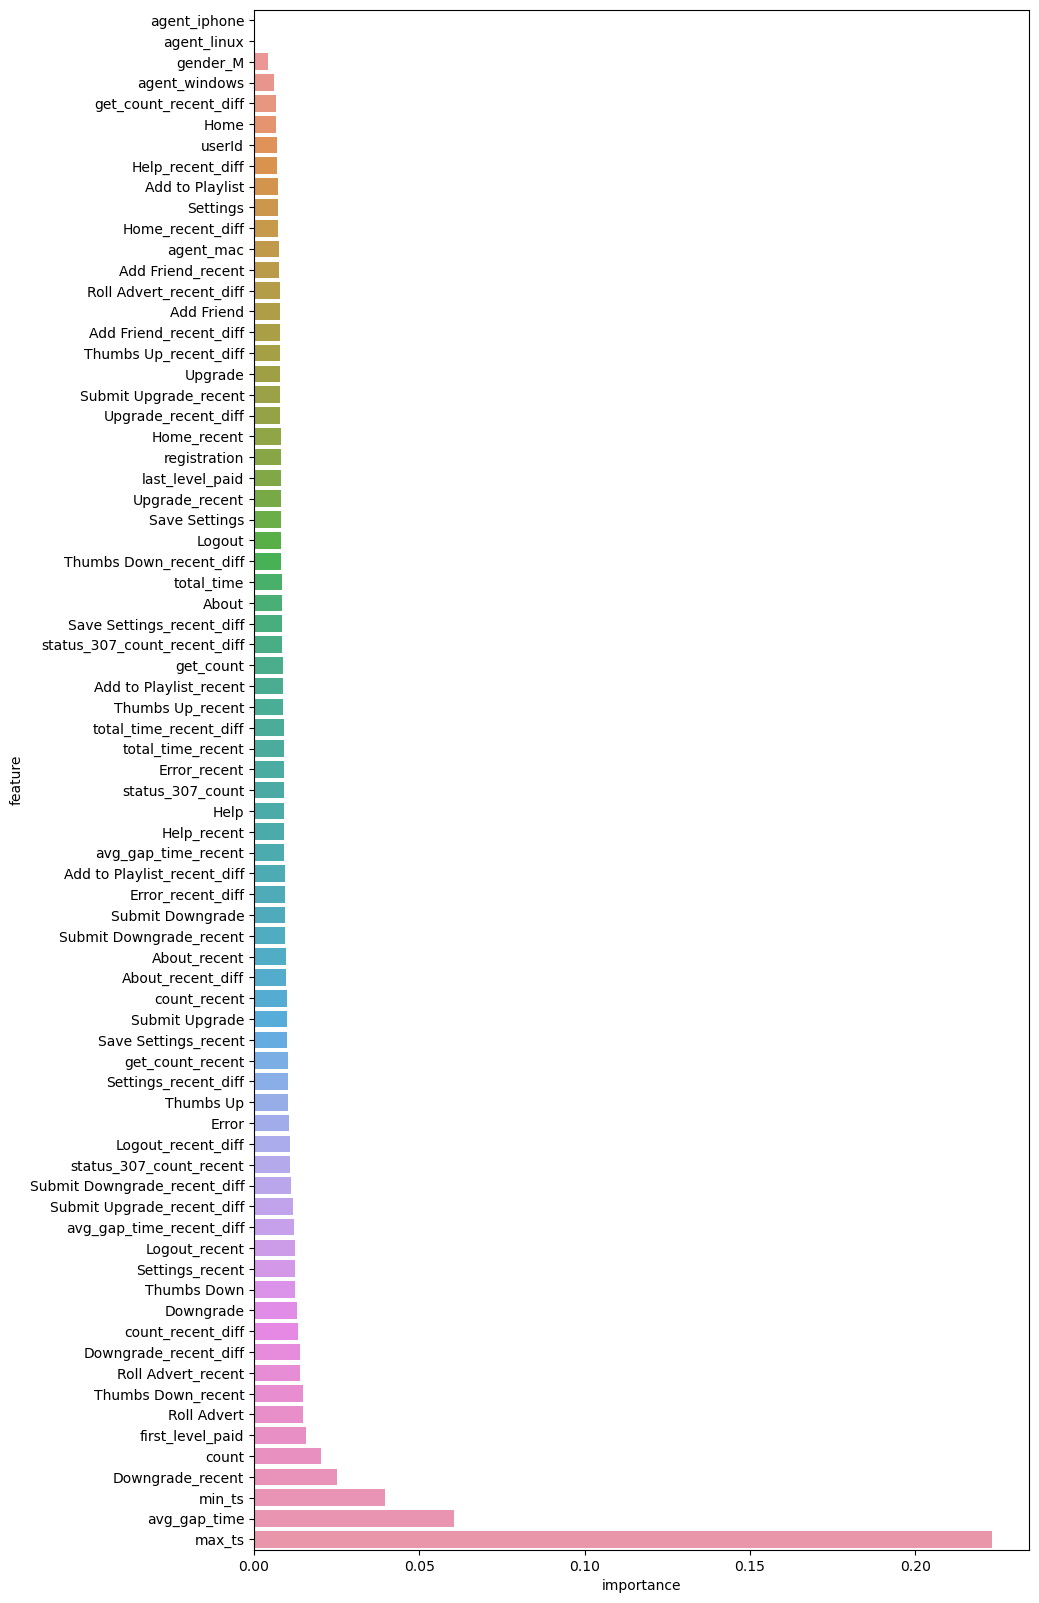

In [56]:
importance_plot(clf_xgb.clfs[0].feature_importances_, feats)

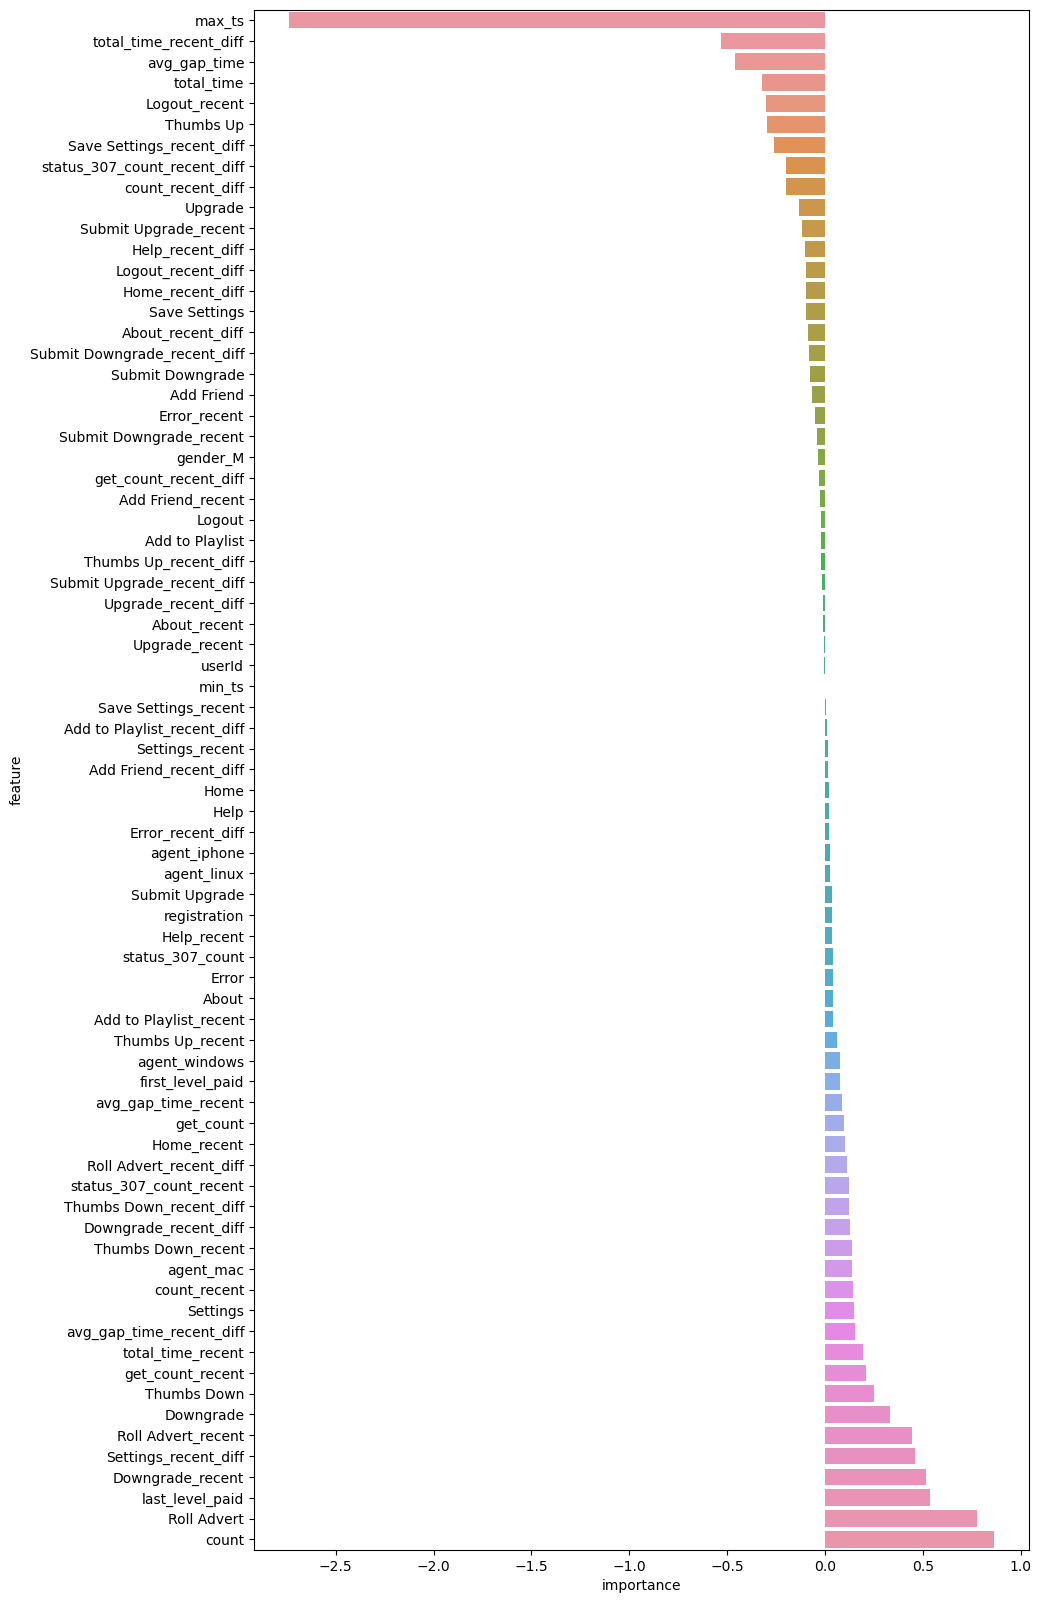

In [58]:
importance_plot(clf_lr[1].coef_, feats)

### both suggest it's better to do something with new users (max_ts, total_time), paid users (paid_level), users with more roll_advert, downgrade and thumbs down actions; see also the shap analysis notebook